# Modeling Hypomania in OCD DBS with Tractography (Clean Version for Yogesh-Nikos-Peter)

## Easy configuration
These are the things you might want to quickly change when debugging this; put up here to make everyone's life easier.

In [ ]:
hypomania_seeds = 1000
ybocs_seeds = 1000


Setup libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt
import sklearn as sklearn
import sklearn.ensemble
import sklearn.inspection
import scipy
from distfit import distfit
from pyglmnet import GLM
from imblearn.over_sampling import SMOTE

np.random.seed(55455)

## Data ingestion (Hypomania Model)
Load the XLSX for hypomania.

In [3]:
dat = pd.read_excel('/Users/alik/Documents/Research/Project Performance/StimVision OCD/2021 YBOCS Modeling Paper/DBS OCD Fiber Analysis August 2021 Cleaned For Distribution.xlsx')
dat.describe()
dat.columns

Index(['Subject', 'Treatment_Weeks', 'Years', 'Hypomanic', 'YBOCS_Raw',
       'MADRS_Raw', 'YBOCS_Pct', 'MADRS_Pct', 'YBOCS_Response',
       'MADRS_Response', 'L_T_ACC-PAC', 'L_Pct_T_ACC-PAC', 'R_T_ACC-PAC',
       'R_Pct_T_ACC-PAC', 'L_T_dlPFC', 'L_Pct_T_dlPFC', 'R_T_dlPFC',
       'R_Pct_T_dlPFC', 'L_T_dmPFC', 'L_Pct_T_dmPFC', 'R_T_dmPFC',
       'R_Pct_T_dmPFC', 'L_T_OFC-Lateral', 'L_Pct_T_OFC-Lateral',
       'R_T_OFC-Lateral', 'R_Pct_T_OFC-Lateral', 'L_T_OFC-Medial',
       'L_Pct_T_OFC-Medial', 'R_T_OFC-Medial', 'R_Pct_T_OFC-Medial',
       'L_T_vlPFC', 'L_Pct_T_vlPFC', 'R_T_vlPFC', 'R_Pct_T_vlPFC', 'L_T_STN',
       'R_T_STN', 'L_Pct_T_STN', 'R_Pct_T_STN', 'L_Charge', 'R_Charge'],
      dtype='object')

For all the columns that are supposed to be numeric data, make them be numeric only.
Make the outcome variable be Boolean.

In [4]:
# Cells marked '0V' are where a stimulation was off. They capture 0 fibers in that tract, so this sets them to zeros.
dat = dat.mask(dat == '0V',other=0)

# Other things, like Peter comments, are stored as strings.
# Coerce the column to numeric, which turns strings into NaNs
number_cols = list(set(dat.columns) - set(['Subject','Date','Hypomanic']))
for c in number_cols:
        dat[c] = pd.to_numeric(dat[c],errors='coerce')
        
# Drop any column where there are >20% NaNs
for c in number_cols:
    if (sum(np.isnan(dat[c])) / dat[c].size) > 0.2 :
        dat = dat.drop(columns=c)
        
# Convert hypomania to a boolean
dat["Hypomanic"] = (dat["Hypomanic"]=='Yes')
hypomania_subjects = dat[dat["Hypomanic"]].Subject.unique()
dat.describe()

,Treatment_Weeks,Years,YBOCS_Raw,MADRS_Raw,YBOCS_Pct,MADRS_Pct,YBOCS_Response,MADRS_Response,L_T_ACC-PAC,L_Pct_T_ACC-PAC,...,L_T_vlPFC,L_Pct_T_vlPFC,R_T_vlPFC,R_Pct_T_vlPFC,L_T_STN,R_T_STN,L_Pct_T_STN,R_Pct_T_STN,L_Charge,R_Charge
count,165.000000,165.000000,150.000000,145.000000,150.000000,145.000000,151.000000,145.000000,165.000000,165.000000,...,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,148.000000,165.000000
mean,65.654545,1.262587,26.233333,27.627586,20.350492,9.325405,0.192053,0.048276,114.787879,0.467268,...,36.769697,0.168965,32.993939,0.079800,17.533333,8.406061,0.113098,0.065286,0.687725,0.683336
std,57.008114,1.096310,5.876145,10.092589,16.048537,34.077293,0.395225,0.215092,88.733555,0.337298,...,71.598697,0.282882,87.566177,0.107273,38.509348,13.910821,0.143301,0.072005,0.470404,0.571877
min,0.000000,0.000000,11.000000,6.000000,-13.333333,-116.666667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.857143,0.266484,22.250000,21.000000,9.531250,-8.333333,0.000000,0.000000,48.000000,0.115385,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.012579,0.000000,0.357375,0.259200
50%,60.571429,1.164835,27.000000,27.000000,15.789474,16.666667,0.000000,0.000000,120.000000,0.459318,...,0.000000,0.000000,10.000000,0.015075,3.000000,2.000000,0.047170,0.062500,0.630000,0.525974
75%,98.857143,1.901099,30.000000,35.000000,28.741776,30.555556,0.000000,0.000000,169.000000,0.780822,...,79.000000,0.356923,24.000000,0.190476,5.000000,10.000000,0.142857,0.125000,0.855000,0.900000
max,242.428571,4.662088,38.000000,54.000000,65.625000,76.470588,1.000000,1.000000,349.000000,0.956164,...,317.000000,0.754386,723.000000,0.666359,153.000000,92.000000,0.443478,0.508287,2.100000,2.550000


In [5]:
number_cols = list(set(dat.columns) - set(['Subject','Date','Hypomanic']))
for c in number_cols:
    
    print(c + " NaN count: " + str(sum(np.isnan(dat[c]))) + " / " + str((dat[c].size)))
#    print(c)

L_Pct_T_ACC-PAC NaN count: 0 / 165
L_Pct_T_dmPFC NaN count: 0 / 165
L_T_OFC-Lateral NaN count: 0 / 165
Treatment_Weeks NaN count: 0 / 165
L_T_STN NaN count: 0 / 165
R_Charge NaN count: 0 / 165
L_Pct_T_OFC-Medial NaN count: 0 / 165
R_T_OFC-Medial NaN count: 0 / 165
R_Pct_T_dlPFC NaN count: 0 / 165
MADRS_Response NaN count: 20 / 165
R_T_STN NaN count: 0 / 165
R_Pct_T_STN NaN count: 0 / 165
L_Pct_T_OFC-Lateral NaN count: 0 / 165
L_Pct_T_vlPFC NaN count: 0 / 165
R_T_dmPFC NaN count: 0 / 165
R_T_vlPFC NaN count: 0 / 165
L_T_dlPFC NaN count: 0 / 165
MADRS_Pct NaN count: 20 / 165
R_T_OFC-Lateral NaN count: 0 / 165
L_T_OFC-Medial NaN count: 0 / 165
R_Pct_T_vlPFC NaN count: 0 / 165
Years NaN count: 0 / 165
L_T_vlPFC NaN count: 0 / 165
L_Pct_T_dlPFC NaN count: 0 / 165
R_T_dlPFC NaN count: 0 / 165
L_T_ACC-PAC NaN count: 0 / 165
R_Pct_T_ACC-PAC NaN count: 0 / 165
YBOCS_Raw NaN count: 15 / 165
R_Pct_T_OFC-Medial NaN count: 0 / 165
R_Pct_T_dmPFC NaN count: 0 / 165
MADRS_Raw NaN count: 20 / 165
L_Cha

Limit the dataset to subjects who had at least one hypomania. Build training/testing splits that are based on the number of hypomanias.

In [6]:
dat_limited = dat.loc[dat.Subject.isin(hypomania_subjects)]
num_hypomania = sum(dat["Hypomanic"])   # coerces booleans to ints to count number of true

# Create a split that will ensure hypomania in both training and test set
split_idx = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2)

# # Uncomment these lines to see what's in the train/test splits
# for train,test in split_idx.split(dat_limited.drop(columns="Hypomanic"),dat_limited["Hypomanic"]):
#        print("TRAIN:" + str(train))
#        print(dat_limited["Hypomanic"].iloc[train])


In [7]:
print("There are " , len(np.unique(dat_limited['Subject'])) , " subjects total with hypomania.")
print("There are", len(dat_limited.loc[dat_limited['Hypomanic']==True,'Hypomanic']),"hypomanic episodes out of",len(dat_limited.index),"total visits.")

There are  3  subjects total with hypomania.
There are 6 hypomanic episodes out of 54 total visits.


In [8]:
# Remove non-tractographic variables as predictors
classify_X = dat_limited.drop(columns=['Subject','Hypomanic','YBOCS_Raw','YBOCS_Pct','MADRS_Raw','MADRS_Pct','YBOCS_Response','MADRS_Response',
                                      'L_Charge','R_Charge','Treatment_Weeks','Years'])
classify_Y = dat_limited['Hypomanic']

# Remove rows with NaNs.
    #  Finds where there are NaNs, np.where gives it as [row,column] lists, the [0] operator gets the row numbers,
    #   np.unique produces just those rows, iloc + index extracts their actual index numbers in the original
    #   dataframe, and then drop does the removal.
nan_rows = classify_X.iloc[np.unique(np.where(classify_X.isna())[0])].index
classify_X = classify_X.drop(index=nan_rows)
classify_Y = classify_Y.drop(index=nan_rows)


# Add "total" variables as regressors.
classify_X.loc[:,"T_All_Regions"] = classify_X.loc[:,~classify_X.columns.str.contains('Pct')].sum(axis=1)
classify_X.loc[:,"Pct_All_Regions"] = classify_X.loc[:,classify_X.columns.str.contains('Pct')].mean(axis=1)

# Useful helper index variables for future
T_idx = ~classify_X.columns.str.contains('Pct')
Pct_idx = classify_X.columns.str.contains('Pct')

# Scale the data before regression, will make importance scoring meaningful
# This turns out to be rather important -- it changes the importance scores, a lot
# Chose a MinMax scaler to get everything onto (0,1).
# But this only should be applied to the non-percentage columns.
# We will actually reapply the normalization just to the training set, down below.
normalizer = sklearn.preprocessing.MinMaxScaler()
classify_X.loc[:,~classify_X.columns.str.contains('Pct')] = normalizer.fit_transform(classify_X.loc[:,~classify_X.columns.str.contains('Pct')])

# For the percentage columns, we just scale them to the 0-1 range using their natural scale.
classify_X.loc[:,classify_X.columns.str.contains('Pct')] = classify_X.loc[:,classify_X.columns.str.contains('Pct')]/100

# Sanity check
We want to know if any of our features are highly correlated with each other. We do expect some correlation b/c some bundles are next to each other.

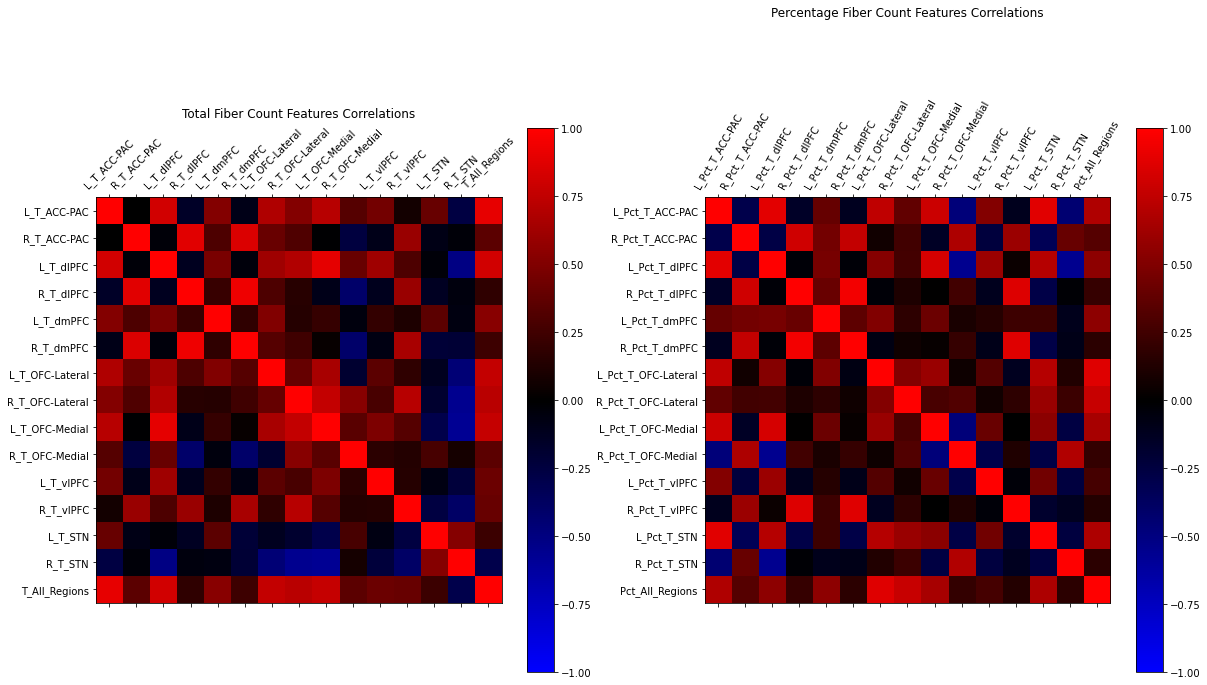

In [9]:
# This is my attemot at a red-black-blue colormap
cdict= {'red': ( (0, 0, 0), (0.5, 0, 0), (1.0, 1, 1)),
       'green' : ( (0, 0, 0), (1, 0, 0)),
       'blue' : ((0, 1, 1), (0.5, 0, 0), (1, 0, 0))}
cm = matplotlib.colors.LinearSegmentedColormap('my_red_blue',cdict)

# This is the plots
f,a = plt.subplots(1,2,figsize=(20,10))
c = a[0].matshow(classify_X.loc[:,T_idx].corr(),cmap=cm,vmin=-1,vmax=1)
a[0].set_xticks(range(classify_X.loc[:,T_idx].shape[1]))
a[0].set_xticklabels(classify_X.loc[:,T_idx].columns,rotation=45)
a[0].set_yticks(range(classify_X.loc[:,T_idx].shape[1]))
a[0].set_yticklabels(classify_X.loc[:,T_idx].columns)
a[0].set_title('Total Fiber Count Features Correlations',pad=80)
plt.colorbar(c,ax=a[0])

c = a[1].matshow(classify_X.loc[:,Pct_idx].corr(),cmap=cm,vmin=-1,vmax=1)
a[1].set_xticks(range(classify_X.loc[:,Pct_idx].shape[1]))
a[1].set_xticklabels(classify_X.loc[:,Pct_idx].columns,rotation=60)
a[1].set_yticks(range(classify_X.loc[:,Pct_idx].shape[1]))
a[1].set_yticklabels(classify_X.loc[:,Pct_idx].columns)
a[1].set_title('Percentage Fiber Count Features Correlations',pad=80)
plt.colorbar(c,ax=a[1])


The "checkerboard" nature suggests that in general, things within the same hemisphere correlate, and tract capture has little correlation across hemispheres. (The latter is good, the former is surprising.) There is not a huge amount of off-diagonal structure, which makes me feel more confident that there is discriminability between different tracts.

# Hypomania - Formal model fitting and testing
This is the section where we do the statistics of the paper, i.e. by doing 1000 model fits for reliable inference.
It assumes the data were already ingested and cleaned; uses the code blocks from above. This specifically includes an assumption that the variables have all been standardized already.

Start by seeding the generator and making consistent random seeds that we'll re-use.

In [10]:
# Make the seeds. The size of model_seeds determines how many model fits we will ultimately do.
random_seed = 55455
num_seeds = hypomania_seeds
gen = np.random.default_rng(random_seed)
model_seeds = gen.integers(1,1e6,size=(1,num_seeds))

Now, perform a large number of fits of four models: penalized L1 logistic regression and random forest, each fit on the "Percentage" and on the "Total" predictor columns. (The number of fits is set in the configuration above.) These are arguably the two most reasonable models, in that both try to select fewer highly leveraged predictors.

In [11]:

# Aggregator dataframe for results
hypomania_results = pd.DataFrame(columns=['SplitIdx','ModelType','Accuracy','BalancedAccuracy','Recall','AUC','Model','TrainIdx','TestIdx'],
                                          dtype='object')

# Helper function to extract core variables from a model and package things like the training/test sets for 
# future re-use.
def summarize_class_scores(model,test_X,test_Y,ModelType,SplitIdx):
    ret_frame = pd.DataFrame(index=[0])
    ret_frame['ModelType'] = ModelType
    ret_frame['SplitIdx'] = SplitIdx
    ret_frame['Accuracy'] = model.score(test_X,test_Y)
    ret_frame['BalancedAccuracy'] = sklearn.metrics.balanced_accuracy_score(test_Y,model.predict(test_X))
    ret_frame['Recall'] = sklearn.metrics.recall_score(test_Y,model.predict(test_X))
    ret_frame['AUC'] = sklearn.metrics.roc_auc_score(test_Y,model.predict(test_X))
    ret_frame.loc[0,'AUC'] = max(ret_frame.loc[0,'AUC'],1-ret_frame.loc[0,'AUC'])
    
    # All of these are wrappers around things we'd need to re-run/re-calculate scores.
    ret_frame['Model'] = [[model]]   # This is buried in a list so we can use models of different types

    return ret_frame

# SMOTE resampler to oversample hypomania cases
sm = SMOTE(sampling_strategy='all',k_neighbors=3)

# Stratified split so we can test each model on a training/test set that contains hypomania.
split_idx = sklearn.model_selection.StratifiedShuffleSplit(n_splits=model_seeds.size, test_size=0.2,random_state=random_seed)

split_num=1

for train_idx,test_idx in split_idx.split(classify_X,classify_Y):

    # Split the data according to this training/testing.
    clean_train_X = classify_X.iloc[train_idx]
    clean_train_Y = classify_Y.iloc[train_idx]
    
    clean_test_X = classify_X.iloc[test_idx]
    clean_test_Y = classify_Y.iloc[test_idx]

    # Fit a normalizer to the training set -- then scale both training AND test the same.
    # (It was already normalized, so this is a small shift, but it will ensure no variance leakage.)
    normalizer.fit(clean_train_X.loc[:,T_idx])
    clean_train_X.loc[:,T_idx] = normalizer.transform(clean_train_X.loc[:,T_idx])
    clean_test_X.loc[:,T_idx] = normalizer.transform(clean_test_X.loc[:,T_idx])

    
    # Upsample the training (NOT THE TEST) data with SMOTE
    resamp_X,resamp_Y = sm.fit_resample(clean_train_X,clean_train_Y)
    
    # This turns resamp_X into a np.array and we need to put it back
    resamp_X = pd.DataFrame(resamp_X)
    resamp_X.columns = clean_train_X.columns
    T_idx = ~resamp_X.columns.str.contains('Pct')
    Pct_idx = resamp_X.columns.str.contains('Pct')
    
    resamp_Y = pd.Series(resamp_Y)
    resamp_Y.columns = ['Hypomanic']
    

    # Fit L1 Penalized Logistic Regression - trying to shrink coefficients.
    mod_l1logit_T = sklearn.linear_model.LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',max_iter=1000).fit(resamp_X.loc[:,T_idx],resamp_Y)
    hypomania_results = hypomania_results.append(summarize_class_scores(mod_l1logit_T,clean_test_X.loc[:,T_idx],clean_test_Y,'L1Logistic_T',split_num),ignore_index=True,sort=False)

    # Fit random forest decision tree
    mod_forest_T = sklearn.ensemble.RandomForestClassifier(class_weight='balanced',n_estimators=100).fit(resamp_X.loc[:,T_idx],resamp_Y)
    hypomania_results = hypomania_results.append(summarize_class_scores(mod_forest_T,clean_test_X.loc[:,T_idx],clean_test_Y,'RandomForest_T',split_num),ignore_index=True,sort=False)
    
    

    # Refit same items to the percentage of fibers, rather than the total of fibers
    mod_l1logit_Pct = sklearn.linear_model.LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',max_iter=1000).fit(resamp_X.loc[:,Pct_idx],resamp_Y)
    hypomania_results = hypomania_results.append(summarize_class_scores(mod_l1logit_Pct,clean_test_X.loc[:,Pct_idx],clean_test_Y,'L1Logistic_Pct',split_num),ignore_index=True,sort=False)
 
    mod_forest_Pct = sklearn.ensemble.RandomForestClassifier(class_weight='balanced',n_estimators=100).fit(resamp_X.loc[:,Pct_idx],resamp_Y)
    hypomania_results = hypomania_results.append(summarize_class_scores(mod_forest_Pct,clean_test_X.loc[:,Pct_idx],clean_test_Y,'RandomForest_Pct',split_num),ignore_index=True,sort=False)

    
    # Store the train/test indexes. The call to tail() gets the rows we just filled. We need to pull their actual numeric index
    # in order to feed it to loc[] so we can then index the specific column.
    # And we wrap the relevant lists inside another list so that it all fits in one dataframe cell.
    # This is probably an abuse of dataframes.
    for j in hypomania_results.tail(4).index:
        hypomania_results.at[j,'TrainIdx'] = [train_idx]
        hypomania_results.at[j,'TestIdx'] = [test_idx]

    # Move forward the CV iterator
    split_num = split_num+1

    
# Uncomment to see the output
#hypomania_results

This next code block summarizes the model performance for the four model types: penalized logistic regression and RandomForest on total or percentage fibers.

In [12]:
# This is the code for pretty-printing that same dataframe
# Stylers are how you format columns: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
#  look at the "slicing" piece of it, and the "Display Values" piece..
# We may also want to use option_context, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.option_context.html#pandas.option_context
model_grouped = hypomania_results.groupby('ModelType')
print_model_grouped = model_grouped.agg([np.median, 
                   lambda x: x.median() - (2*x.std()) ,
                   lambda x: x.median() + (2*x.std())]).rename(columns={'median':'Median', '<lambda_0>' : 'CI Lower Bound' , '<lambda_1>' : 'CI Upper Bound'})
print_model_grouped.columns.set_levels(['AUC','Accuracy','Balanced Accuracy','Recall'],level=0,inplace=True)  # must set in alphabetical order
print_model_grouped = print_model_grouped.drop(columns=['Accuracy'])
print_model_grouped[np.abs(print_model_grouped) < 1e-8] = 0
print_model_grouped.index.names = ['Model Type']
print_model_grouped.index = pd.Index(['L1 Logistic (Percentage)','L1 Logistic (Total Fibers)','Random Forest (Percentage)','Random Forest (Total Fibers)'])

print_model_grouped[print_model_grouped > 1] = 1  # Fix AUCs and accuracy > 1 (due to bad SD math)
print_model_grouped[print_model_grouped < 0] = 0

display(print_model_grouped.style.format("{:.3f}"))

Balanced Accuracy is my primary metric, although AUC would be of interest. There seems to be a slight advantage for the percent-activation models in this.

However, note that these models in general fail to predict hypomania well. They have zero median recall, and none has a CI that excludes zero recall. That is, none has clinical utility (maybe to be expected on this sparse a dataset).

Next, importance scoring: across these logistic regressions, which variables are consistently weighted with high or low coefficients?
Here, negative coefficients imply that something is protective.

In [13]:
# Obtain the mean coefficient values for each type of model.
coef_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)
for i in hypomania_results.loc[hypomania_results['ModelType'].str.contains('Logistic_Pct')].index :
    coef_agg.loc[i,clean_test_X.loc[:,Pct_idx].columns] = hypomania_results.loc[i,'Model'][0].coef_[0]
for i in hypomania_results.loc[hypomania_results['ModelType'].str.contains('Logistic_T')].index :
    coef_agg.loc[i,clean_test_X.loc[:,T_idx].columns] = hypomania_results.loc[i,'Model'][0].coef_[0]

# coef_agg.loc[:,clean_test_X.loc[:,T_idx].columns]     # this is a valid way to index just some columns
# This will display the Pct and T coefficients together for importance scoring.
#coef_agg.reset_index(inplace=True)
t = pd.concat([coef_agg.mean(),coef_agg.std()],axis=1)
t.columns = ['CoeffMean','CoeffStd']
t.sort_values('CoeffMean')

,CoeffMean,CoeffStd
L_T_STN,-1.777651,0.883915
L_T_dlPFC,-1.614110,1.408211
L_T_dmPFC,-0.365998,0.834684
L_T_vlPFC,-0.353601,0.670744
L_T_ACC-PAC,-0.121392,0.378476
L_T_OFC-Lateral,-0.093578,0.343485
R_T_dlPFC,-0.031207,0.151131
R_T_vlPFC,-0.018000,0.130096
T_All_Regions,-0.000274,0.008679
R_Pct_T_STN,0.000000,0.000000


Pretty-print total fibers version for the paper.

In [14]:
# Pretty-print coefficients table, Total fibers version
Pct_plot_idx = (t.index.str.contains('Pct')) & np.array(np.abs(t.loc[:,'CoeffMean']) > 0)
T_plot_idx = (~t.index.str.contains('Pct')) & np.array(np.abs(t.loc[:,'CoeffMean']) > 0)

pretty_t = t
pretty_t.columns = pd.Index(['Mean Coefficient','SD'])
#pretty_t.index.rename((pd.Series(pretty_t.index.array).replace(regex={r'Pct_':'' ,'_T_':' ', '_':' '})))
d={'Pct_':'' ,'_T_':' ', '_':' '}
for k,v in d.items():
    pretty_t.index = pretty_t.index.str.replace(k,v)
    
def bold_signif(s):
    if (np.abs(s[0]) >= (2*s[1])):
        return pd.Series(['font-weight: bold',''])
    else:
        return pd.Series(['',''])

display(pretty_t.loc[T_plot_idx,:].\
        sort_values(by='Mean Coefficient').\
        style.set_caption("Total Fibers").\
        format("{:.3f}").\
        apply(bold_signif,axis=1))

display(pretty_t.loc[Pct_plot_idx,:].\
        sort_values(by='Mean Coefficient').\
        style.set_caption("Percentage Capture").\
        format("{:.3f}").\
        apply(bold_signif,axis=1))

,Mean Coefficient,SD
L STN,-1.778,0.884
L dlPFC,-1.614,1.408
L dmPFC,-0.366,0.835
L vlPFC,-0.354,0.671
L ACC-PAC,-0.121,0.378
L OFC-Lateral,-0.094,0.343
R dlPFC,-0.031,0.151
R vlPFC,-0.018,0.130
T All Regions,-0.000,0.009
R ACC-PAC,0.031,0.310


,Mean Coefficient,SD


Total-fibers boxplot, nicely formatted.

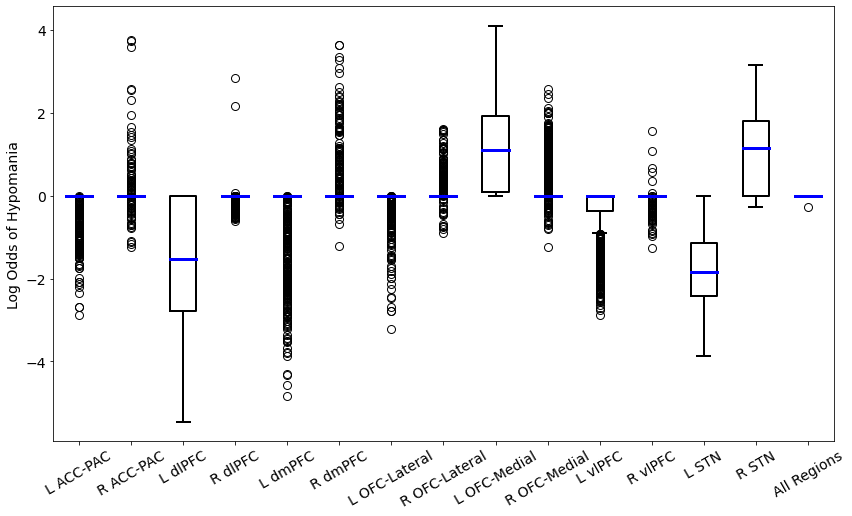

In [15]:
# Pretty ploting of coefficients.
# https://matplotlib.org/examples/pylab_examples/boxplot_demo2.html

# Condense to nonzero coefficients
pretty_plot = coef_agg.loc[coef_agg.sum(axis=1)!=0,
                                 (coef_agg.mean() != 0) & (~coef_agg.columns.str.contains('Pct'))]

# Replace names
d={'Pct_':'' ,'_T_':' ', '_':' ','T ':''}
for k,v in d.items():
    pretty_plot.columns = pretty_plot.columns.str.replace(k,v)

# Styling. This applies to everything we don't overwrite in the "boxplot" call.
boxstyle = dict(linewidth=2,color='black')
medstyle = dict(linewidth=3,color='blue')

f1,a1 = plt.subplots(figsize=(14,8))
p1 = a1.boxplot(pretty_plot,\
                   boxprops=boxstyle,whiskerprops=boxstyle,capprops=boxstyle,\
                   medianprops=medstyle,\
               flierprops=dict(markersize=8))

# I do not know why this needs to be done as this nested call
trash=plt.setp(plt.setp(a1,xticklabels=np.array(pretty_plot.columns)),\
               rotation=30,\
              fontsize=14)
trash=plt.setp(a1.get_yticklabels(),\
               fontsize=14)
trash=plt.ylabel("Log Odds of Hypomania",fontsize=14)

plt.savefig("Hypomania_Boxplot.png",dpi=300)

Now we do the same with the random forest models. We use "permutation importance". https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html explains it. Basically, this goes through each column of the dataset and asks "how much does accuracy drop if you permute this column?"

In [16]:
# Aggregator frame for results.
perm_importance_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)

# Number of permutation runs on each model (doesn't need to be many bc we fit so many models)
# 5 is the default setting for sklearn
nperms = 5

for i in hypomania_results.loc[hypomania_results['ModelType'].str.contains('Forest_Pct')].index :
    imp = sklearn.inspection.permutation_importance(hypomania_results.loc[i,'Model'][0] ,
                                                    classify_X.iloc[hypomania_results.loc[i,'TestIdx'][0],Pct_idx],
                                                    classify_Y.iloc[hypomania_results.loc[i,'TestIdx'][0]],
                                                    n_repeats=nperms)
    perm_importance_agg.loc[i,classify_X.loc[:,Pct_idx].columns] = imp['importances_mean']
    
for i in hypomania_results.loc[hypomania_results['ModelType'].str.contains('Forest_T')].index :
    imp = sklearn.inspection.permutation_importance(hypomania_results.loc[i,'Model'][0] ,
                                                    classify_X.iloc[hypomania_results.loc[i,'TestIdx'][0],T_idx],
                                                    classify_Y.iloc[hypomania_results.loc[i,'TestIdx'][0]],
                                                    n_repeats=nperms)
    perm_importance_agg.loc[i,classify_X.loc[:,T_idx].columns] = imp['importances_mean']

pd.DataFrame(perm_importance_agg.mean(),columns=['MeanImportance']).sort_values('MeanImportance')

,MeanImportance
Pct_All_Regions,-0.005945
L_Pct_T_dmPFC,-0.005818
L_T_STN,-0.004345
L_Pct_T_dlPFC,-0.004182
L_Pct_T_STN,-0.003764
R_Pct_T_dmPFC,-0.002764
L_T_dlPFC,-0.002727
L_Pct_T_OFC-Medial,-0.002618
L_Pct_T_ACC-PAC,-0.001382
R_Pct_T_OFC-Lateral,-0.000964


<AxesSubplot:>

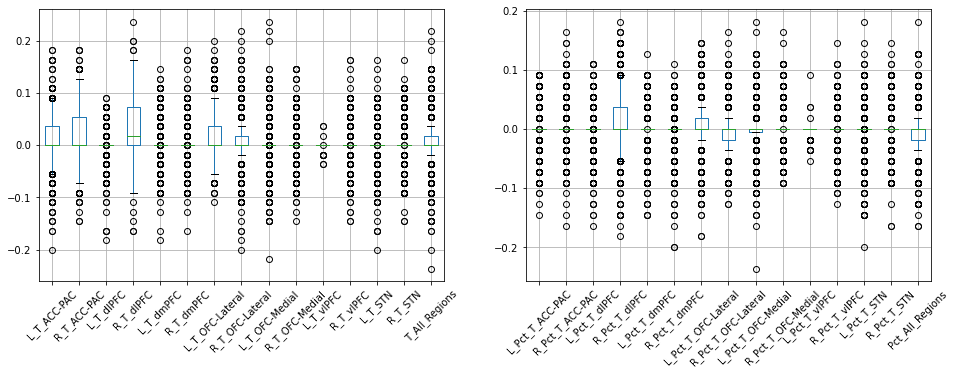

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,5))
perm_importance_agg.loc[:,(perm_importance_agg.mean() != 0) & (~perm_importance_agg.columns.str.contains('Pct'))].boxplot(ax=ax[0],rot=45)
perm_importance_agg.loc[:,(perm_importance_agg.mean() != 0) & (perm_importance_agg.columns.str.contains('Pct'))].boxplot(ax=ax[1],rot=45)
#coef_agg.loc[:,(coef_agg.mean() != 0) & (coef_agg.columns.str.contains('Pct'))].boxplot(ax=ax[1],rot=45)

# YBOCS - Formal model fitting and testing
Now all the same thing, but continuous and logistic regression on the YBOCS, which means we have a much larger dataset.
This analysis all uses percentage YBOCS drop. I have tried this on the raw YBOCS and it doesn't make much of a difference.

Re-seed the generator to the same set of random seeds.

In [18]:
num_seeds = ybocs_seeds
random_seed = 55455
gen = np.random.default_rng(random_seed)
model_seeds = gen.integers(1,1e6,size=(1,num_seeds))

First, let's verify that linear regression models (or their ilk) are valid. This is the probability density of percent-change scores across the entire dataset.

In [19]:
# Re-load the dataset to get all subjects.
dat = pd.read_excel('/Users/alik/Documents/Research/Project Performance/StimVision OCD/2021 YBOCS Modeling Paper/DBS OCD Fiber Analysis August 2021 Cleaned For Distribution.xlsx')
#dat.describe()
#dat.columns

# Cells marked '0V' are where a stimulation was off. They capture 0 fibers in that tract, so this sets them to zeros.
dat = dat.mask(dat == '0V',other=0)

# Other things, like Peter comments, are stored as strings.
# Coerce the column to numeric, which turns strings into NaNs
number_cols = list(set(dat.columns) - set(['Subject','Date','Hypomanic'] ))
for c in number_cols:
        dat[c] = pd.to_numeric(dat[c],errors='coerce')
        
# Drop any column where there are >20% NaNs
for c in number_cols:
    if (sum(np.isnan(dat[c])) / dat[c].size) > 0.2 :
        dat = dat.drop(columns=c)
        
# Convert hypomania to a boolean
dat["Hypomanic"] = (dat["Hypomanic"]=='Yes')
dat.describe()

print("The mean YBOCS drop, using each patient's best day, was ",
      np.mean(dat.loc[:,['Subject','YBOCS_Pct']].groupby('Subject').agg(np.max).values))

The mean YBOCS drop, using each patient's best day, was  46.59753325001837


Text(0, 0.5, 'Density')

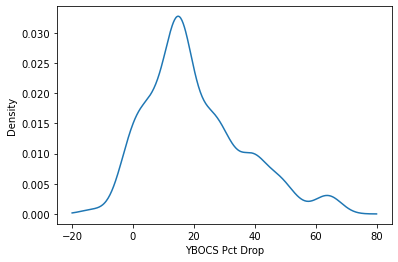

In [20]:

# Regression tables -- the core dataframe with key items removed, and YBOCS percent improvement as the dependent var.
regress_Y = dat['YBOCS_Pct']
regress_X = dat.drop(columns=['Subject','Hypomanic','YBOCS_Raw','YBOCS_Pct','MADRS_Raw','MADRS_Pct','YBOCS_Response','MADRS_Response',
                              'Treatment_Weeks','Years','L_Charge','R_Charge'])

# Clean the data by removing rows with NaNs.
    #  Finds where there are NaNs, np.where gives it as [row,column] lists, the [0] operator gets the row numbers,
    #   np.unique producesa just those rows, iloc + index extracts their actual index numbers in the original
    #   dataframe, and then drop does the removal.
nan_rows = regress_X.iloc[np.union1d(np.unique(np.where(regress_X.isna())),np.unique(np.where(regress_Y.isna())))].index
regress_X = regress_X.drop(index=nan_rows)
regress_Y = regress_Y.drop(index=nan_rows)
regress_groups = dat.loc[regress_X.index,'Subject']

# Plot a kernel density. We need to np.exp() the value of the estimator b/c it returns log-likelihood.
# the calls to reshape() and np.newaxis are magic copied from the web, have to do with how a numpy array codes its own dimensions.
ksd = sklearn.neighbors.KernelDensity(kernel='gaussian',bandwidth=4).fit(np.array(regress_Y).reshape(-1,1))
ksd_x = np.linspace(-20,80,500)[:,np.newaxis]
ax = plt.axes()
ax.plot(ksd_x,np.exp(ksd.score_samples(ksd_x)))
ax.set_xlabel('YBOCS Pct Drop')
ax.set_ylabel('Density')

That is close to Gaussian, but the tail makes me suspicious. So let's check with the distfit package:

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0078413] [loc=20.350 scale=15.995]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0133065] [loc=-13.333 scale=33.684]
[distfit] >[pareto    ] [0.06 sec] [RSS: 0.0136328] [loc=-986675372.076 scale=986675358.743]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 0.0073532] [loc=18.064 scale=12.994]
[distfit] >[t         ] [0.05 sec] [RSS: 0.0076876] [loc=19.642 scale=14.834]
[distfit] >[genextreme] [0.10 sec] [RSS: 0.0070139] [loc=13.231 scale=13.030]
[distfit] >[gamma     ] [0.01 sec] [RSS: 0.0070791] [loc=-20.882 scale=6.090]
[distfit] >[lognorm   ] [0.04 sec] [RSS: 0.0431751] [loc=-13.334 scale=2.809]
[distfit] >[beta      ] [0.08 sec] [RSS: 0.0070762] [loc=-20.247 scale=14172557.843]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0111923] [loc=-13.333 scale=78.958]
[distfit] >[loggamma  ] [0.05 sec] [RSS: 0.0078910] [loc=-4178.151 scale=586.610]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot summar

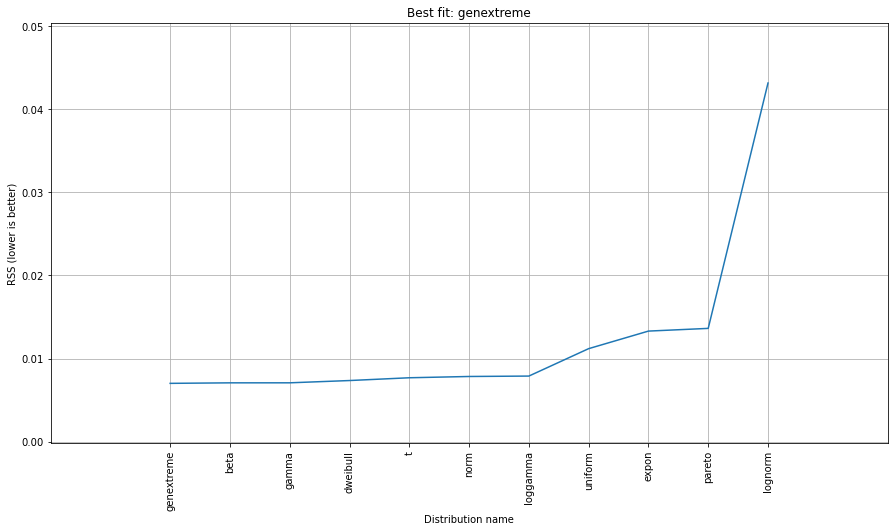

         distr       score  LLE          loc        scale  \
0   genextreme  0.00701394  NaN      13.2315      13.0304   
1         beta   0.0070762  NaN     -20.2471  1.41726e+07   
2        gamma  0.00707913  NaN     -20.8817       6.0897   
3     dweibull  0.00735324  NaN      18.0643      12.9941   
4            t  0.00768764  NaN      19.6422      14.8337   
5         norm  0.00784129  NaN      20.3505       15.995   
6     loggamma  0.00789097  NaN     -4178.15       586.61   
7      uniform   0.0111923  NaN     -13.3333      78.9583   
8        expon   0.0133065  NaN     -13.3333      33.6838   
9       pareto   0.0136328  NaN -9.86675e+08  9.86675e+08   
10     lognorm   0.0431751  NaN     -13.3337      2.80927   

                                      arg  
0                   (0.0366363195155158,)  
1   (6.480040177597259, 2260525.90849228)  
2                    (6.770807873618351,)  
3                   (1.1668419507911096,)  
4                    (13.21626800683219,)  
5  

In [21]:
df = distfit()
df.fit_transform(regress_Y)
df.plot_summary()
print(df.summary)

The best fits are extreme and beta (which are difficult to combine with regularization), gamma, and log-normal. So we use a gamma GLM with our LASSO because it's the best fit that is compatible. Also note that basically, once you get down below uniform, they are all REALLY close to each other.

In [22]:
# Data preparation.

# Add the "total fibers" columns again.

regress_X.loc[:,"T_All_Regions"] = regress_X.loc[:,~regress_X.columns.str.contains('Pct')].sum(axis=1)
regress_X.loc[:,"Pct_All_Regions"] = regress_X.loc[:,regress_X.columns.str.contains('Pct')].mean(axis=1)

# Need the column indices for Total fiber and Percentage data.
T_idx = ~regress_X.columns.str.contains('Pct')
Pct_idx = regress_X.columns.str.contains('Pct')


# Scale the data before regression, will make importance scoring meaningful
# This turns out to be rather important -- it changes the importance scores, a lot
# Chose a MinMax scaler to get everything onto (0,1).
# But this only should be applied to the non-percentage columns.
# As before, we are also going to re-normalize to just training set when we fit models.
normalizer = sklearn.preprocessing.MinMaxScaler()
regress_X.loc[:,T_idx] = normalizer.fit_transform(regress_X.loc[:,T_idx])

# For the percentage columns, we just scale them to the 0-1 range using their natural scale.
regress_X.loc[:,Pct_idx] = regress_X.loc[:,Pct_idx]/100

In [23]:
# Data analysis.
# Aggregator dataframe for results
ybocs_results = pd.DataFrame(columns=['SplitIdx','ModelType','R2','ExpVar','RMSE','Model','TrainIdx','TestIdx'],
                                          dtype='object')






# Helper function to extract performance variables from a model and package things like the training/test sets for 
# future re-use.
def summarize_regression_scores(model,test_X,test_Y,ModelType,SplitIdx):
    ret_frame = pd.DataFrame(index=[0])
    ret_frame['ModelType'] = ModelType
    ret_frame['SplitIdx'] = SplitIdx
    ret_frame['R2'] = sklearn.metrics.r2_score(test_Y,model.predict(test_X))
    ret_frame['ExpVar'] = sklearn.metrics.explained_variance_score(test_Y,model.predict(test_X))
    ret_frame['RMSE'] = sklearn.metrics.mean_squared_error(test_Y,model.predict(test_X),squared=False)
    
    # All of these are wrappers around things we'd need to re-run/re-calculate scores.
    ret_frame['Model'] = [[model]]   # This is buried in a list so we can use models of different types

    return ret_frame


# Stratified split along subjects.
# Note that an exhaustive split may end up ignoring the number of seeds.
#split_idx = sklearn.model_selection.GroupShuffleSplit(n_splits=model_seeds.size, test_size=0.2, random_state=random_seed)
split_idx=sklearn.model_selection.LeavePGroupsOut(n_groups=2)

# Iterate through the splits.
split_num=1
for train_idx,test_idx in split_idx.split(regress_X,regress_Y,regress_groups):

    # Split the data according to this training/testing.
    clean_train_X = regress_X.iloc[train_idx]
    clean_train_Y = regress_Y.iloc[train_idx]
    
    clean_test_X = regress_X.iloc[test_idx]
    clean_test_Y = regress_Y.iloc[test_idx]

    # Fit a normalizer to the training set -- then scale both training AND test the same.
    # (It was already normalized, so this is a small shift, but it will ensure no variance leakage.)
    normalizer.fit(clean_train_X.loc[:,T_idx])
    clean_train_X.loc[:,T_idx] = normalizer.transform(clean_train_X.loc[:,T_idx])
    clean_test_X.loc[:,T_idx] = normalizer.transform(clean_test_X.loc[:,T_idx])

    
    # We do not perform a SMOTE here, because there is no "minority" class.
    
    # Fit L1 Lasso Regression
#    mod_l1ybocs_T = sklearn.linear_model.Lasso(max_iter=5000).fit(clean_train_X.loc[:,T_idx],clean_train_Y)
#    ybocs_results = ybocs_results.append(summarize_regression_scores(mod_l1ybocs_T,clean_test_X.loc[:,T_idx],clean_test_Y,'Lasso_T',split_num),ignore_index=True,sort=False)
    mod_l1ybocs_T = GLM(distr='gamma',alpha=1.0,max_iter=1000).fit(clean_train_X.loc[:,T_idx].to_numpy(),clean_train_Y.to_numpy())
    ybocs_results = ybocs_results.append(summarize_regression_scores(mod_l1ybocs_T,clean_test_X.loc[:,T_idx].to_numpy(),clean_test_Y.to_numpy(),'Lasso_T',split_num),ignore_index=True,sort=False)

    # Fit random forest regression
    mod_forestybocs_T = sklearn.ensemble.RandomForestRegressor(criterion='mse',n_estimators=100).fit(clean_train_X.loc[:,T_idx],clean_train_Y)
    ybocs_results = ybocs_results.append(summarize_regression_scores(mod_forestybocs_T,clean_test_X.loc[:,T_idx],clean_test_Y,'RandomForest_T',split_num),ignore_index=True,sort=False)


    # Refit same items to the percentage of fibers, rather than the total of fibers
#     mod_l1ybocs_Pct = sklearn.linear_model.Lasso(max_iter=1000).fit(clean_train_X.loc[:,Pct_idx],clean_train_Y)
#     ybocs_results = ybocs_results.append(summarize_regression_scores(mod_l1ybocs_Pct,clean_test_X.loc[:,Pct_idx],clean_test_Y,'Lasso_Pct',split_num),ignore_index=True,sort=False)

    mod_l1ybocs_Pct = GLM(distr='gamma',alpha=1.0,max_iter=1000).fit(clean_train_X.loc[:,Pct_idx].to_numpy(),clean_train_Y.to_numpy())
    ybocs_results = ybocs_results.append(summarize_regression_scores(mod_l1ybocs_Pct,clean_test_X.loc[:,Pct_idx].to_numpy(),clean_test_Y.to_numpy(),'Lasso_Pct',split_num),ignore_index=True,sort=False)

    mod_forestybocs_Pct = sklearn.ensemble.RandomForestRegressor(criterion='mse',n_estimators=100).fit(clean_train_X.loc[:,Pct_idx],clean_train_Y)
    ybocs_results = ybocs_results.append(summarize_regression_scores(mod_forestybocs_Pct,clean_test_X.loc[:,Pct_idx],clean_test_Y,'RandomForest_Pct',split_num),ignore_index=True,sort=False)
    
    # Store the train/test indexes. The call to tail() gets the rows we just filled. We need to pull their actual numeric index
    # in order to feed it to loc[] so we can then index the specific column.
    # And we wrap the relevant lists inside another list so that it all fits in one dataframe cell.
    # This is probably an abuse of dataframes.
    for j in ybocs_results.tail(4).index:
        ybocs_results.at[j,'TrainIdx'] = [train_idx]
        ybocs_results.at[j,'TestIdx'] = [test_idx]

    # Move forward the CV iterator
    split_num = split_num+1

    
# Uncomment to see the output
#ybocs_results 

In [24]:
# This is sanity-check code and can be ignored.
#np.unique(regress_groups.iloc[ybocs_results.loc[36,'TestIdx'][0]])
for i in range(0,ybocs_results.index.size,4):
    tr = np.unique(regress_groups.iloc[ybocs_results.loc[i,'TrainIdx'][0]])
    te = np.unique(regress_groups.iloc[ybocs_results.loc[i,'TestIdx'][0]])
    if (np.intersect1d(tr,te).size > 0):
        print("Iteration ",i," has train-test overlap")
#regress_groups.iloc[[0,1,2,3]]


We again fit a large number of models, then summarize the results acrss models. The "RMSE" will be on the scale of the percentage drop in YBOCS. "R2" reports the improvement relative to a null model. Larger is better, values below zero imply cause for concern (model is no better than chance). "ExpVar" is the explained variance in the dependent variable. There are again two models: a LASSO regression (to shrink coefficients and select only important features) and a Random Forest Regression, and again we consider total-fiber and percentage-capture metrics as two separate analyses.

In [25]:
# This is the code for pretty-printing that same dataframe
# Stylers are how you format columns: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
#  look at the "slicing" piece of it, and the "Display Values" piece..
# We may also want to use option_context, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.option_context.html#pandas.option_context

model_grouped = ybocs_results.groupby('ModelType')
print_model_grouped = model_grouped.agg([np.median, 
                   lambda x: x.median() - (2*x.std()) ,
                   lambda x: x.median() + (2*x.std())]).rename(columns={'median':'Median', '<lambda_0>' : 'CI Lower Bound' , '<lambda_1>' : 'CI Upper Bound'})
print_model_grouped = print_model_grouped.drop(columns=['RMSE'])
print_model_grouped[np.abs(print_model_grouped) < 1e-8] = 0
print_model_grouped.columns.set_levels(['Explained Variance','R$^2$'],level=0,inplace=True)
print_model_grouped.index = pd.Index(['L1 Regression (Percentage)','L1 Regression (Total Fibers)','Random Forest (Percentage)','Random Forest (Total Fibers)'])
#print_model_grouped.index.names = ['Model Type']

display(print_model_grouped.style.format("{:.3f}"))

All the R2 median values are below zero, as the explained variances. This implies that, in general, it is not possible to predict YBOCS change from the tracts we've studied.

Despite lack of significance, let's still look at importance scoring (coefficient averaging) on the YBOCS regressors. The data are encoded as percentage improvement, so higher coefficients are good. Because they are all pre-standardized, they can reasonably be compared to each other.

In [26]:
# Obtain the mean coefficient values for each type of model.
coef_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)

# for i in ybocs_results.loc[ybocs_results['ModelType'].str.contains('Lasso_Pct')].index :
#     coef_agg.loc[i,clean_test_X.loc[:,Pct_idx].columns] = ybocs_results.loc[i,'Model'][0].coef_[0]
# for i in ybocs_results.loc[ybocs_results['ModelType'].str.contains('Lasso_T')].index :
#     coef_agg.loc[i,clean_test_X.loc[:,T_idx].columns] = ybocs_results.loc[i,'Model'][0].coef_[0]

for i in ybocs_results.loc[ybocs_results['ModelType'].str.contains('Lasso_Pct')].index :
    coef_agg.loc[i,clean_test_X.loc[:,Pct_idx].columns] = ybocs_results.loc[i,'Model'][0].beta_
for i in ybocs_results.loc[ybocs_results['ModelType'].str.contains('Lasso_T')].index :
    coef_agg.loc[i,clean_test_X.loc[:,T_idx].columns] = ybocs_results.loc[i,'Model'][0].beta_

# coef_agg.loc[:,clean_test_X.loc[:,T_idx].columns]     # this is a valid way to index just some columns
# This will display the Pct and T coefficients together for importance scoring.
#coef_agg.reset_index(inplace=True)
t = pd.concat([coef_agg.mean(),coef_agg.std()],axis=1)
t.columns = ['CoeffMean','CoeffStd']
t.sort_values('CoeffMean')

,CoeffMean,CoeffStd
L_T_ACC-PAC,0.0,0.0
R_Pct_T_STN,0.0,0.0
L_Pct_T_STN,0.0,0.0
R_T_STN,0.0,0.0
L_T_STN,0.0,0.0
R_Pct_T_vlPFC,0.0,0.0
R_T_vlPFC,0.0,0.0
L_Pct_T_vlPFC,0.0,0.0
L_T_vlPFC,0.0,0.0
R_Pct_T_OFC-Medial,0.0,0.0


In these revised versions, basically nothing has a coefficient; the regressions just call the mean.


We can also look at random forest importance:

In [27]:
# Aggregator frame for results.
regress_importance_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)

# Number of permutation runs on each model (doesn't need to be many bc we fit so many models)
# 5 is the default setting for sklearn
nperms = 5

for i in ybocs_results.loc[ybocs_results['ModelType'].str.contains('Forest_Pct')].index :
    imp = sklearn.inspection.permutation_importance(ybocs_results.loc[i,'Model'][0] ,
                                                    regress_X.iloc[ybocs_results.loc[i,'TestIdx'][0],Pct_idx],
                                                    regress_Y.iloc[ybocs_results.loc[i,'TestIdx'][0]],
                                                    n_repeats=nperms)
    regress_importance_agg.loc[i,regress_X.loc[:,Pct_idx].columns] = imp['importances_mean']
    
for i in ybocs_results.loc[ybocs_results['ModelType'].str.contains('Forest_T')].index :
    imp = sklearn.inspection.permutation_importance(ybocs_results.loc[i,'Model'][0] ,
                                                    regress_X.iloc[ybocs_results.loc[i,'TestIdx'][0],T_idx],
                                                    regress_Y.iloc[ybocs_results.loc[i,'TestIdx'][0]],
                                                    n_repeats=nperms)
    regress_importance_agg.loc[i,regress_X.loc[:,T_idx].columns] = imp['importances_mean']

t = pd.concat([regress_importance_agg.mean(),regress_importance_agg.std()],axis=1)
t.columns = ['ImportanceMean','ImportanceStd']
t.sort_values('ImportanceMean')

,ImportanceMean,ImportanceStd
L_Pct_T_STN,-0.076319,0.230171
L_T_dmPFC,-0.060891,0.098391
L_T_dlPFC,-0.056866,0.145849
R_Pct_T_ACC-PAC,-0.047682,0.189183
R_T_ACC-PAC,-0.042386,0.139580
L_T_OFC-Lateral,-0.039806,0.167176
R_T_dmPFC,-0.036006,0.107986
R_T_dlPFC,-0.033560,0.188262
R_Pct_T_dmPFC,-0.031623,0.118325
R_Pct_T_OFC-Medial,-0.031238,0.073377


These importance scores are basically R^2 values (on that scale). Basically they are the change in R^2 from permuting a given model. (This is because R^2 is the default scorer for RandomForestRegressor.)

Overall, I again interpret this as nothing significant, since all of these intervals cover 0.

## Sanity check -- YBOCS models on the MADRS
We want to prove that this model is very specific to YBOCS prediction. So, let's take our trained models and run them on both YBOCS and MADRS to see what happens.

First, a sanity check: how much are the YBOCS and MADRS improvement correlated?

0.3497236700279855 correlation between YBOCS and MADRS percentage drop.


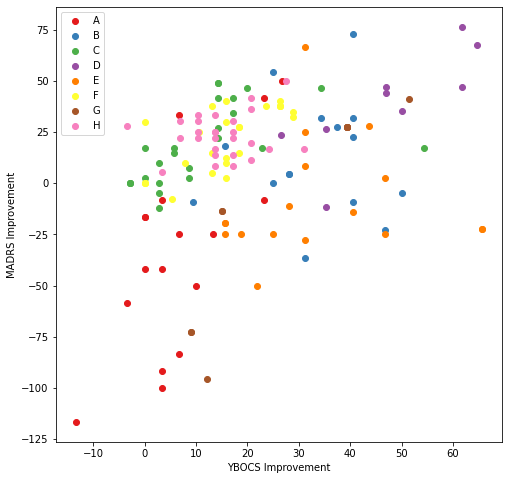

In [28]:
fig,ax=plt.subplots(1,1,figsize=(8,8))

i=0
scalarMap = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=len(np.unique(dat['Subject']))),cmap=plt.get_cmap('Set1'))
for sub,subdat in dat.groupby(by='Subject'):
    plt.scatter(subdat['YBOCS_Pct'],subdat['MADRS_Pct'],label=sub,c=[scalarMap.to_rgba(i)])
#    print(i)
    i=i+1
ax.set_xlabel('YBOCS Improvement')
ax.set_ylabel('MADRS Improvement')
ax.legend()

tempdrop = np.union1d(np.where(dat['MADRS_Pct'].isna()),nan_rows)
tempdrop = np.union1d(np.where(dat['YBOCS_Pct'].isna()),tempdrop)

r = scipy.stats.pearsonr(dat['YBOCS_Pct'].drop(index=tempdrop),
                                      dat['MADRS_Pct'].drop(index=tempdrop))
print(r[0],"correlation between YBOCS and MADRS percentage drop.")

Modestly at best. Though visually, it holds across subjects. So how does the predictive power for each of our YBOCS models compare to its ability to predict the held-out MADRS data?

In [29]:
# Aggregator dataframe for results
madrs_from_ybocs = pd.DataFrame(columns=['ModelType','RMSE_YBOCS','RMSE_MADRS'],
                                          dtype='float64')

# Alternate Y-values
MADRS = dat.loc[regress_Y.index,'MADRS_Pct']

for i in ybocs_results.index:
    madrs_from_ybocs.loc[i,'ModelType'] = ybocs_results.loc[i,'ModelType']
    madrs_from_ybocs.loc[i,'RMSE_YBOCS'] = ybocs_results.loc[i,'RMSE']
    
    if '_Pct' in ybocs_results.loc[i,'ModelType']:
        col_idx = Pct_idx
    else:
        col_idx = T_idx
        
    test_idx = ybocs_results.loc[i,'TestIdx'][0]
    
    # The MADRS sometimes has NaNs that weren't in YBOCS, so we add a hack.
    temp_y = MADRS.iloc[np.where(~MADRS.iloc[test_idx].isna())]
    temp_x = regress_X.iloc[np.where(~MADRS.iloc[test_idx].isna())]
    temp_x = temp_x.iloc[:,col_idx]

    
    madrs_from_ybocs.loc[i,'RMSE_MADRS'] = sklearn.metrics.mean_squared_error(temp_y,
                                                                              ybocs_results.loc[i,'Model'][0].predict(temp_x.to_numpy()),
                                                                              squared=False)
# Uncomment to see the raw output
#print(madrs_from_ybocs)


print(sum(madrs_from_ybocs['RMSE_YBOCS'] < madrs_from_ybocs['RMSE_MADRS']) / len(madrs_from_ybocs.index)*100, "% of models score better on YBOCS than MADRS")
model_grouped = madrs_from_ybocs.groupby('ModelType')
model_grouped.agg([np.median, 
                   lambda x: x.median() - (2*x.std()) ,
                   lambda x: x.median() + (2*x.std())]).rename(columns={'median':'median', '<lambda_0>' : 'CI_lower' , '<lambda_1>' : 'CI_upper'})



100.0 % of models score better on YBOCS than MADRS


RMSE_YBOCS                       RMSE_MADRS             \
                     median   CI_lower   CI_upper     median   CI_lower   
ModelType                                                                 
Lasso_Pct         16.502973   6.113271  26.892676  50.678029  40.884622   
Lasso_T           16.510322   6.105623  26.915021  50.669234  40.876548   
RandomForest_Pct  20.878708  13.550355  28.207062  47.999053  35.588751   
RandomForest_T    21.672452  15.151159  28.193745  47.718723  33.434535   

                             
                   CI_upper  
ModelType                    
Lasso_Pct         60.471437  
Lasso_T           60.461919  
RandomForest_Pct  60.409356  
RandomForest_T    62.002912

That is, we are definitely fitting a model that is specific to the YBOCS. These are on the scale of percentage improvement for each, so they should be comparable.

# Response / nonresponse categorical prediction

This is attempting to predict whether the patient is in a clinical (non)response status at each timepoint, based on the captured fibers.
We can basically reuse the regression model's X data, but now with the same classification code used for hypomania.

Re-seed again.

In [30]:
num_seeds = ybocs_seeds
random_seed = 55455
gen = np.random.default_rng(random_seed)
model_seeds = gen.integers(1,1e6,size=(1,num_seeds))

Setup a logistic regression/classifier, now using categorical OCD response as dependent variable.
The pre-processing was already done, and standardizing happens within the CV loop.

In [31]:
response_Y = dat['YBOCS_Response'] == 1

# Remove NaNs, using the same drops as the prior YBOCS dataset  
response_Y = response_Y.drop(index=nan_rows)
response_X = regress_X

In [32]:
# # Sanity check and model inspection as needed
# response_Y
# np.mean(response_Y)
print(len(dat.loc[dat['YBOCS_Response']==1,'YBOCS_Response']),"visits contained YBOCS response out of",len(dat.index),"total visits (before NaN drops).")
print(len(np.unique(dat.loc[dat['YBOCS_Response']==1,'Subject'])),"patients had at least one response, out of",
      len(np.unique(dat['Subject'])),"total patients.")

29 visits contained YBOCS response out of 165 total visits (before NaN drops).
5 patients had at least one response, out of 8 total patients.


In [33]:
# Repeated model fitting
# Aggregator dataframe for results
response_results = pd.DataFrame(columns=['SplitIdx','ModelType','Accuracy','BalancedAccuracy','Recall','AUC','Model','TrainIdx','TestIdx'],
                                          dtype='object')

# Helper function to extract core variables from a model and package things like the training/test sets for 
# future re-use.
def summarize_class_scores(model,test_X,test_Y,ModelType,SplitIdx):
    ret_frame = pd.DataFrame(index=[0])
    ret_frame['ModelType'] = ModelType
    ret_frame['SplitIdx'] = SplitIdx
    ret_frame['Accuracy'] = model.score(test_X,test_Y)
    ret_frame['BalancedAccuracy'] = sklearn.metrics.balanced_accuracy_score(test_Y,model.predict(test_X))
    ret_frame['Recall'] = sklearn.metrics.recall_score(test_Y,model.predict(test_X))
    ret_frame['AUC'] = sklearn.metrics.roc_auc_score(test_Y,model.predict(test_X))
    ret_frame.loc[0,'AUC'] = max(ret_frame.loc[0,'AUC'],1-ret_frame.loc[0,'AUC'])
    
    # All of these are wrappers around things we'd need to re-run/re-calculate scores.
    ret_frame['Model'] = [[model]]   # This is buried in a list so we can use models of different types

    return ret_frame

# SMOTE resampler to upsample and balance response/nonresponse
sm = SMOTE(sampling_strategy='all',k_neighbors=3)

# # Stratified split so we can test each model on a training/test set that contains both types.
# split_idx = sklearn.model_selection.StratifiedShuffleSplit(n_splits=model_seeds.size, test_size=0.2,random_state=random_seed)

# I have replaced the stratified split with a split based on patients again.
# It requires a little bit of fix for when we get all nonresponse in the test fold, see below
#split_idx = sklearn.model_selection.GroupShuffleSplit(n_splits=model_seeds.size, test_size=0.2, random_state=random_seed)
split_idx = sklearn.model_selection.LeavePGroupsOut(n_groups=int(np.ceil(0.2*len(pd.Series.unique(dat['Subject'])))))

# Iterate through the splits.
split_num=1
response_groups = dat.loc[response_X.index,'Subject']
for train_idx,test_idx in split_idx.split(response_X,response_Y,response_groups):

    # Split the data according to this training/testing.
    clean_train_X = response_X.iloc[train_idx]
    clean_train_Y = response_Y.iloc[train_idx]
    
    clean_test_X = response_X.iloc[test_idx]
    clean_test_Y = response_Y.iloc[test_idx]

    # Fit a normalizer to the training set -- then scale both training AND test the same.
    # (It was already normalized, so this is a small shift, but it will ensure no variance leakage.)
    normalizer.fit(clean_train_X.loc[:,T_idx])
    clean_train_X.loc[:,T_idx] = normalizer.transform(clean_train_X.loc[:,T_idx])
    clean_test_X.loc[:,T_idx] = normalizer.transform(clean_test_X.loc[:,T_idx])

    # Upsample the training (NOT THE TEST) data with SMOTE
    resamp_X,resamp_Y = sm.fit_resample(clean_train_X,clean_train_Y)
    
    # This turns resamp_X into a np.array and we need to put it back
    resamp_X = pd.DataFrame(resamp_X)
    resamp_X.columns = clean_train_X.columns
    T_idx = ~resamp_X.columns.str.contains('Pct')
    Pct_idx = resamp_X.columns.str.contains('Pct')
    
    resamp_Y = pd.Series(resamp_Y)
    resamp_Y.columns = ['YBOCS_Response']
    

    # Every so often, we get a test fold that doesn't have any TRUE responses. randomly flip one.
    if sum(clean_test_Y) == 0:
        clean_test_Y.iloc[np.random.randint(1,len(clean_test_Y))]=True

    # Fit L1 Penalized Logistic Regression - trying to shrink coefficients.
    mod_l1logit_T = sklearn.linear_model.LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',max_iter=1000).fit(resamp_X.loc[:,T_idx],resamp_Y)
    response_results = response_results.append(summarize_class_scores(mod_l1logit_T,clean_test_X.loc[:,T_idx],clean_test_Y,'L1Logistic_T',split_num),ignore_index=True,sort=False)

    # Fit random forest decision tree
    mod_forest_T = sklearn.ensemble.RandomForestClassifier(class_weight='balanced',n_estimators=100).fit(resamp_X.loc[:,T_idx],resamp_Y)
    response_results = response_results.append(summarize_class_scores(mod_forest_T,clean_test_X.loc[:,T_idx],clean_test_Y,'RandomForest_T',split_num),ignore_index=True,sort=False)
    
    

    # Refit same items to the percentage of fibers, rather than the total of fibers
    mod_l1logit_Pct = sklearn.linear_model.LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',max_iter=1000).fit(resamp_X.loc[:,Pct_idx],resamp_Y)
    response_results = response_results.append(summarize_class_scores(mod_l1logit_Pct,clean_test_X.loc[:,Pct_idx],clean_test_Y,'L1Logistic_Pct',split_num),ignore_index=True,sort=False)
 
    mod_forest_Pct = sklearn.ensemble.RandomForestClassifier(class_weight='balanced',n_estimators=100).fit(resamp_X.loc[:,Pct_idx],resamp_Y)
    response_results = response_results.append(summarize_class_scores(mod_forest_Pct,clean_test_X.loc[:,Pct_idx],clean_test_Y,'RandomForest_Pct',split_num),ignore_index=True,sort=False)

    
    # Store the train/test indexes. The call to tail() gets the rows we just filled. We need to pull their actual numeric index
    # in order to feed it to loc[] so we can then index the specific column.
    # And we wrap the relevant lists inside another list so that it all fits in one dataframe cell.
    # This is probably an abuse of dataframes.
    for j in response_results.tail(4).index:
        response_results.at[j,'TrainIdx'] = [train_idx]
        response_results.at[j,'TestIdx'] = [test_idx]

    # Move forward the CV iterator
    split_num = split_num+1

    
# Uncomment to see the output
#response_results

Summarize the output. 

In [34]:
# This is the code for pretty-printing that same dataframe
# Stylers are how you format columns: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
#  look at the "slicing" piece of it, and the "Display Values" piece..
# We may also want to use option_context, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.option_context.html#pandas.option_context

model_grouped = response_results.groupby('ModelType')
print_model_grouped = model_grouped.agg([np.median, 
                   lambda x: x.median() - (2*x.std()) ,
                   lambda x: x.median() + (2*x.std())]).rename(columns={'median':'Median', '<lambda_0>' : 'CI Lower Bound' , '<lambda_1>' : 'CI Upper Bound'})
#print_model_grouped.columns.set_levels(['Accuracy','Balanced Accuracy','Recall','AUC'],level=0,inplace=True)
print_model_grouped.columns.set_levels(['AUC','Accuracy','Balanced Accuracy','Recall'],level=0,inplace=True)
print_model_grouped = print_model_grouped.drop(columns=['Accuracy'])
print_model_grouped[np.abs(print_model_grouped) < 1e-8] = 0
print_model_grouped.index.names = ['Model Type']
print_model_grouped.index = pd.Index(['L1 Logistic (Percentage)','L1 Logistic (Total Fibers)','Random Forest (Percentage)','Random Forest (Total Fibers)'])

display(print_model_grouped.style.format("{:.3f}"))

The confidence interval for both Balanced Accuracy and AUC  include 0.5, meaning that we cannot predict this categorical response either.

Next, coefficient scoring -- what's leveraged towards predicting response (coded as 1)?

In [35]:
# Obtain the mean coefficient values for each type of model.
ybocs_coef_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)
for i in response_results.loc[response_results['ModelType'].str.contains('Logistic_Pct')].index :
    ybocs_coef_agg.loc[i,clean_test_X.loc[:,Pct_idx].columns] = response_results.loc[i,'Model'][0].coef_[0]
for i in response_results.loc[response_results['ModelType'].str.contains('Logistic_T')].index :
    ybocs_coef_agg.loc[i,clean_test_X.loc[:,T_idx].columns] = response_results.loc[i,'Model'][0].coef_[0]

# ybocs_coef_agg.loc[:,clean_test_X.loc[:,T_idx].columns]     # this is a valid way to index just some columns
# This will display the Pct and T coefficients together for importance scoring.
#ybocs_coef_agg.reset_index(inplace=True)
t = pd.concat([ybocs_coef_agg.mean(),ybocs_coef_agg.std()],axis=1)

Pretty-printing of the table, with significant coefficients highlighted.

In [38]:
# Pretty-print coefficients table, Total fibers version
#t = pd.concat([ybocs_coef_agg.mean(),ybocs_coef_agg.std()],axis=1)
t = pd.concat([ybocs_coef_agg.mean(),ybocs_coef_agg.std()],axis=1)
t.columns = ['CoeffMean','CoeffStd']
t.sort_values('CoeffMean')

Pct_plot_idx = (t.index.str.contains('Pct')) & np.array(np.abs(t.loc[:,'CoeffMean']) > 0)
T_plot_idx = (~t.index.str.contains('Pct')) & np.array(np.abs(t.loc[:,'CoeffMean']) > 0)
pretty_t = t.loc[T_plot_idx,].sort_values('CoeffMean')
pretty_t.columns = pd.Index(['Mean Coefficient','SD'])
#pretty_t.index.rename((pd.Series(pretty_t.index.array).replace(regex={r'Pct_':'' ,'_T_':' ', '_':' '})))
d={'Pct_':'' ,'_T_':' ', '_':' '}
for k,v in d.items():
    pretty_t.index = pretty_t.index.str.replace(k,v)

def bold_signif(s):
    if (np.abs(s[0]) >= (2*s[1])):
        return pd.Series(['font-weight: bold',''])
    else:
        return pd.Series(['',''])
    
display(pretty_t.style.\
        format("{:.3f}").\
        apply(bold_signif,axis=1))


,Mean Coefficient,SD
L OFC-Medial,-6.806,3.718
L vlPFC,-3.107,2.679
R OFC-Medial,-1.690,1.780
R OFC-Lateral,-0.477,1.847
R dlPFC,-0.464,1.648
R STN,-0.404,0.787
L dlPFC,-0.347,1.029
L dmPFC,-0.305,0.776
R ACC-PAC,-0.047,1.104
R vlPFC,-0.046,0.244


Boxplot of coefficients, pretty-printed version.

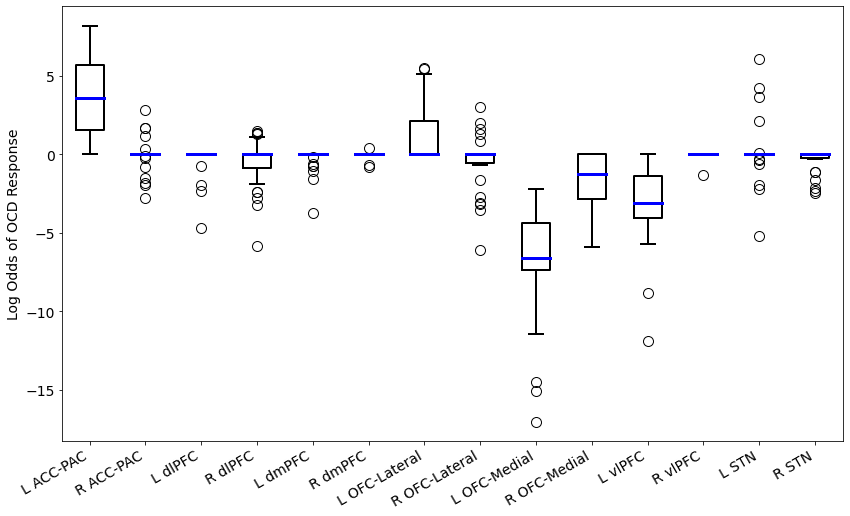

In [39]:
# Pretty ploting of coefficients.
# https://matplotlib.org/examples/pylab_examples/boxplot_demo2.html

# Condense to nonzero coefficients
pretty_plot = ybocs_coef_agg.loc[ybocs_coef_agg.sum(axis=1)!=0,(ybocs_coef_agg.mean() != 0) & (~ybocs_coef_agg.columns.str.contains('Pct'))]

# Replace names
d={'Pct_':'' ,'_T_':' ', '_':' '}
for k,v in d.items():
    pretty_plot.columns = pretty_plot.columns.str.replace(k,v)

# Styling. This applies to everything we don't overwrite in the "boxplot" call.
boxstyle = dict(linewidth=2,color='black')
medstyle = dict(linewidth=3,color='blue')

f1,a1 = plt.subplots(figsize=(14,8))
p1 = a1.boxplot(pretty_plot,\
                   boxprops=boxstyle,whiskerprops=boxstyle,capprops=boxstyle,\
                   medianprops=medstyle,\
               flierprops=dict(markersize=10))

# I do not know why this needs to be done as this nested call
trash=plt.setp(plt.setp(a1,xticklabels=np.array(pretty_plot.columns)),\
              fontsize=14)
trash=plt.setp(a1.get_yticklabels(),\
               fontsize=14)
trash=a1.set_xticklabels(a1.get_xticklabels(),rotation=30,ha='right')
trash = plt.ylabel("Log Odds of OCD Response",fontsize=14)

plt.savefig("YBOCS_Response_Boxplot.png",dpi=300)

We could interpret this as saying that
- Getting cingulate and lateral OFC fibers may be therapeutic
- Getting medial OFC fibers is profoundly not. Which is interesting because we traditionally think of OFC as key to the DBS mechanisms.
- STN is not significant, but is numerically in the direction of being non-therapeutic.


And random forest importance.

In [40]:
# Aggregator frame for results.
perm_importance_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)

# Number of permutation runs on each model (doesn't need to be many bc we fit so many models)
# 5 is the default setting for sklearn
nperms = 5

for i in response_results.loc[response_results['ModelType'].str.contains('Forest_Pct')].index :
    imp = sklearn.inspection.permutation_importance(response_results.loc[i,'Model'][0] ,
                                                    response_X.iloc[response_results.loc[i,'TestIdx'][0],Pct_idx],
                                                    response_Y.iloc[response_results.loc[i,'TestIdx'][0]],
                                                    n_repeats=nperms)
    perm_importance_agg.loc[i,response_X.loc[:,Pct_idx].columns] = imp['importances_mean']
    
for i in response_results.loc[response_results['ModelType'].str.contains('Forest_T')].index :
    imp = sklearn.inspection.permutation_importance(response_results.loc[i,'Model'][0] ,
                                                    response_X.iloc[response_results.loc[i,'TestIdx'][0],T_idx],
                                                    response_Y.iloc[response_results.loc[i,'TestIdx'][0]],
                                                    n_repeats=nperms)
    perm_importance_agg.loc[i,response_X.loc[:,T_idx].columns] = imp['importances_mean']



In [41]:
t = pd.concat([perm_importance_agg.mean(),perm_importance_agg.std()],axis=1).\
rename(columns={0:'MeanImportance', 1:'SDImportance'}).\
sort_values('MeanImportance')

t

,MeanImportance,SDImportance
L_T_OFC-Lateral,-0.021874,0.042176
R_Pct_T_dmPFC,-0.013913,0.035804
R_Pct_T_vlPFC,-0.013563,0.021005
L_T_ACC-PAC,-0.012942,0.062866
L_T_STN,-0.011768,0.032906
R_T_OFC-Lateral,-0.010360,0.032136
R_Pct_T_ACC-PAC,-0.009868,0.040501
L_Pct_T_dmPFC,-0.008360,0.018237
R_T_dlPFC,-0.007659,0.047944
L_T_dlPFC,-0.007493,0.033360


<AxesSubplot:>

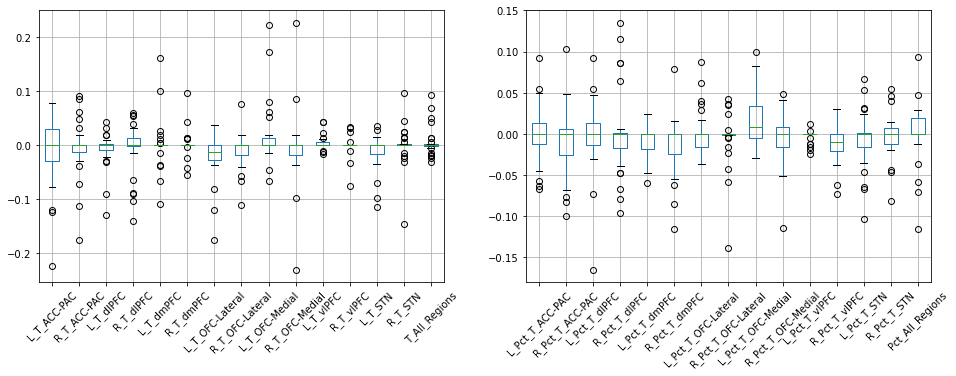

In [42]:
# Boxplot of importance scoring
fig,ax = plt.subplots(1,2,figsize=(16,5))
perm_importance_agg.loc[:,(perm_importance_agg.mean() != 0) & (~perm_importance_agg.columns.str.contains('Pct'))].boxplot(ax=ax[0],rot=45)
perm_importance_agg.loc[:,(perm_importance_agg.mean() != 0) & (perm_importance_agg.columns.str.contains('Pct'))].boxplot(ax=ax[1],rot=45)
#coef_agg.loc[:,(coef_agg.mean() != 0) & (coef_agg.columns.str.contains('Pct'))].boxplot(ax=ax[1],rot=45)

# Response / nonresponse categorical prediction on MADRS instead of YBOCS

One thing we could ask -- do the same features predict MADRS and YBOCS responder status, which we might expect?

We can first look at the correlation between those two binary variables.

[[113   4]
 [ 25   3]]
Correlation between YBOCS and MADRS response: 0.134


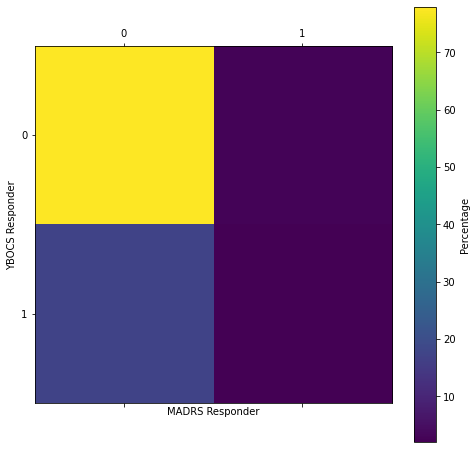

In [43]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

nan_rows=np.union1d(np.where(dat['MADRS_Response'].isna()),nan_rows)

cm = sklearn.metrics.confusion_matrix(dat['YBOCS_Response'].drop(index=nan_rows),
                                      dat['MADRS_Response'].drop(index=nan_rows))
print(cm)
r=scipy.stats.pearsonr(dat['YBOCS_Response'].drop(index=nan_rows),
                                      dat['MADRS_Response'].drop(index=nan_rows))
print("Correlation between YBOCS and MADRS response: %.3f" % r[0])
sax=ax.matshow(100*cm/sum(sum(cm)))
cb=fig.colorbar(sax)
#ax.set_xticlabel
ax.set_xlabel('MADRS Responder')
ax.set_ylabel('YBOCS Responder')
cb.set_label('Percentage')

They are correlated only in the sense that they tend to be zero most of the time, but otherwise, they are not very correlated. There are particularly more times when someone is a MADRS but not a YBOCS responder.

So now we redo the exact same model training, fitting, etc. as we did for the YBOCS response. We do need to adjust the SMOTE resampler because there are fewer MADRS responses than YBOCS responses in this dataset.

In [44]:
# Re-seed the generators again.
num_seeds = ybocs_seeds
random_seed = 55455
gen = np.random.default_rng(random_seed)
model_seeds = gen.integers(1,1e6,size=(1,num_seeds))


In [45]:
# Convert the MADRS response (stored as numbers) to a boolean
response_Y = dat.loc[regress_X.index,'MADRS_Response'] == 1

# Remove NaNs, but NOT the same drops as before, b/c we might have discordant YBOCS and MADRS response.
nan_rows = regress_X.iloc[np.union1d(np.unique(np.where(regress_X.isna())),np.unique(np.where(response_Y.isna())))].index

response_Y = response_Y.drop(index=np.intersect1d(regress_Y.index,nan_rows))
response_X = regress_X.drop(index=np.intersect1d(regress_X.index,nan_rows))

print(len(dat.loc[dat['MADRS_Response']==1,'MADRS_Response']),"visits contained MADRS response out of",len(dat.index),"total visits.")
print(len(np.unique(dat.loc[dat['MADRS_Response']==1,'Subject'])),"patients had at least one response, out of",
      len(np.unique(dat['Subject'])),"total patients.")
print("The mean MADRS drop, using each patient's best day, was ",
      np.mean(dat.loc[:,['Subject','MADRS_Pct']].groupby('Subject').agg(np.max).values))

7 visits contained MADRS response out of 165 total visits.
5 patients had at least one response, out of 8 total patients.
The mean MADRS drop, using each patient's best day, was  55.69426329290031


In [46]:
# Repeated model fitting
# Aggregator dataframe for results
madrs_response_results = pd.DataFrame(columns=['SplitIdx','ModelType','Accuracy','BalancedAccuracy','Recall','AUC','Model','TrainIdx','TestIdx'],
                                          dtype='object')

# Helper function to extract core variables from a model and package things like the training/test sets for 
# future re-use.
def summarize_class_scores(model,test_X,test_Y,ModelType,SplitIdx):
    ret_frame = pd.DataFrame(index=[0])
    ret_frame['ModelType'] = ModelType
    ret_frame['SplitIdx'] = SplitIdx
    ret_frame['Accuracy'] = model.score(test_X,test_Y)
    ret_frame['BalancedAccuracy'] = sklearn.metrics.balanced_accuracy_score(test_Y,model.predict(test_X))
    ret_frame['Recall'] = sklearn.metrics.recall_score(test_Y,model.predict(test_X))
    ret_frame['AUC'] = sklearn.metrics.roc_auc_score(test_Y,model.predict(test_X))
    ret_frame.loc[0,'AUC'] = max(ret_frame.loc[0,'AUC'],1-ret_frame.loc[0,'AUC'])
    
    # All of these are wrappers around things we'd need to re-run/re-calculate scores.
    ret_frame['Model'] = [[model]]   # This is buried in a list so we can use models of different types

    return ret_frame

# SMOTE resampler to upsample and balance response/nonresponse
sm = SMOTE(sampling_strategy='all',k_neighbors=2)


# This was old code that is now deprecated
# # Stratified split so we can test each model on a training/test set that contains both types.
# split_idx = sklearn.model_selection.StratifiedShuffleSplit(n_splits=model_seeds.size, test_size=0.2,random_state=random_seed)
# split_num=1
# for train_idx,test_idx in split_idx.split(response_X,response_Y):

#split_idx = sklearn.model_selection.GroupShuffleSplit(n_splits=model_seeds.size, test_size=0.2, random_state=random_seed)
split_idx = sklearn.model_selection.LeavePGroupsOut(n_groups=int(np.ceil(0.2*len(pd.Series.unique(dat['Subject'])))))

# Iterate through the splits.
split_num=1
response_groups = dat.loc[response_X.index,'Subject']
for train_idx,test_idx in split_idx.split(response_X,response_Y,response_groups):
    
    # Split the data according to this training/testing.
    clean_train_X = response_X.iloc[train_idx]
    clean_train_Y = response_Y.iloc[train_idx]
    
    clean_test_X = response_X.iloc[test_idx]
    clean_test_Y = response_Y.iloc[test_idx]
    
    # Fit a normalizer to the training set -- then scale both training AND test the same.
    # (It was already normalized, so this is a small shift, but it will ensure no variance leakage.)
    normalizer.fit(clean_train_X.loc[:,T_idx])
    clean_train_X.loc[:,T_idx] = normalizer.transform(clean_train_X.loc[:,T_idx])
    clean_test_X.loc[:,T_idx] = normalizer.transform(clean_test_X.loc[:,T_idx])


    # Upsample the training (NOT THE TEST) data with SMOTE
    resamp_X,resamp_Y = sm.fit_resample(clean_train_X,clean_train_Y)
    
    # This turns resamp_X into a np.array and we need to put it back
    resamp_X = pd.DataFrame(resamp_X)
    resamp_X.columns = clean_train_X.columns
    T_idx = ~resamp_X.columns.str.contains('Pct')
    Pct_idx = resamp_X.columns.str.contains('Pct')
    
    resamp_Y = pd.Series(resamp_Y)
    resamp_Y.columns = ['MADRS_Response']
    
    
    # Every so often, we get a test fold that doesn't have any TRUE responses. randomly flip one.
    if sum(clean_test_Y) == 0:
        clean_test_Y.iloc[np.random.randint(1,len(clean_test_Y))]=True

    # Fit L1 Penalized Logistic Regression - trying to shrink coefficients.
    mod_l1logit_T = sklearn.linear_model.LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',max_iter=1000).fit(resamp_X.loc[:,T_idx],resamp_Y)
    madrs_response_results = madrs_response_results.append(summarize_class_scores(mod_l1logit_T,clean_test_X.loc[:,T_idx],clean_test_Y,'L1Logistic_T',split_num),ignore_index=True,sort=False)

    # Fit random forest decision tree
    mod_forest_T = sklearn.ensemble.RandomForestClassifier(class_weight='balanced',n_estimators=100).fit(resamp_X.loc[:,T_idx],resamp_Y)
    madrs_response_results = madrs_response_results.append(summarize_class_scores(mod_forest_T,clean_test_X.loc[:,T_idx],clean_test_Y,'RandomForest_T',split_num),ignore_index=True,sort=False)
    
    

    # Refit same items to the percentage of fibers, rather than the total of fibers
    mod_l1logit_Pct = sklearn.linear_model.LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',max_iter=1000).fit(resamp_X.loc[:,Pct_idx],resamp_Y)
    madrs_response_results = madrs_response_results.append(summarize_class_scores(mod_l1logit_Pct,clean_test_X.loc[:,Pct_idx],clean_test_Y,'L1Logistic_Pct',split_num),ignore_index=True,sort=False)
 
    mod_forest_Pct = sklearn.ensemble.RandomForestClassifier(class_weight='balanced',n_estimators=100).fit(resamp_X.loc[:,Pct_idx],resamp_Y)
    madrs_response_results = madrs_response_results.append(summarize_class_scores(mod_forest_Pct,clean_test_X.loc[:,Pct_idx],clean_test_Y,'RandomForest_Pct',split_num),ignore_index=True,sort=False)

    
    # Store the train/test indexes. The call to tail() gets the rows we just filled. We need to pull their actual numeric index
    # in order to feed it to loc[] so we can then index the specific column.
    # And we wrap the relevant lists inside another list so that it all fits in one dataframe cell.
    # This is probably an abuse of dataframes.
    for j in madrs_response_results.tail(4).index:
        madrs_response_results.at[j,'TrainIdx'] = [train_idx]
        madrs_response_results.at[j,'TestIdx'] = [test_idx]

    # Move forward the CV iterator
    split_num = split_num+1

    
# Uncomment to see the output
#madrs_response_results

And we can pretty-print that.

In [47]:
# This is the code for pretty-printing that same dataframe
# Stylers are how you format columns: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
#  look at the "slicing" piece of it, and the "Display Values" piece..
# We may also want to use option_context, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.option_context.html#pandas.option_context

model_grouped = response_results.groupby('ModelType')
print_model_grouped = model_grouped.agg([np.median, 
                   lambda x: x.median() - (2*x.std()) ,
                   lambda x: x.median() + (2*x.std())]).rename(columns={'median':'Median', '<lambda_0>' : 'CI Lower Bound' , '<lambda_1>' : 'CI Upper Bound'})

# Note that levels are stored alpha order, NOT the order that they print/display!!
print_model_grouped.columns.set_levels(['AUC','Accuracy','Balanced Accuracy','Recall'],level=0,inplace=True)
print_model_grouped = print_model_grouped.drop(columns=['Accuracy'])
print_model_grouped[np.abs(print_model_grouped) < 1e-8] = 0
print_model_grouped.index.names = ['Model Type']
print_model_grouped.index = pd.Index(['L1 Logistic (Percentage)','L1 Logistic (Total Fibers)','Random Forest (Percentage)','Random Forest (Total Fibers)'])

print_model_grouped[print_model_grouped > 1] = 1  # Fix AUCs and accuracy > 1 (due to bad SD math)
print_model_grouped[print_model_grouped < 0] = 0

display(print_model_grouped.style.format("{:.3f}"))

So for this model also, the  accuracy does not exceed chance. 

I still find it interesting that the randpm forest doesn't do better than the L1-Logistic.

We can still coefficient-score those regression models:

In [48]:
# Obtain the mean coefficient values for each type of model.
madrs_coef_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)
for i in madrs_response_results.loc[response_results['ModelType'].str.contains('Logistic_Pct')].index :
    madrs_coef_agg.loc[i,clean_test_X.loc[:,Pct_idx].columns] = madrs_response_results.loc[i,'Model'][0].coef_[0]
for i in madrs_response_results.loc[response_results['ModelType'].str.contains('Logistic_T')].index :
    madrs_coef_agg.loc[i,clean_test_X.loc[:,T_idx].columns] = madrs_response_results.loc[i,'Model'][0].coef_[0]

# madrs_coef_agg.loc[:,clean_test_X.loc[:,T_idx].columns]     # this is a valid way to index just some columns
# This will display the Pct and T coefficients together for importance scoring.
#madrs_coef_agg.reset_index(inplace=True)
t = pd.concat([madrs_coef_agg.mean(),madrs_coef_agg.std()],axis=1)
t.columns = ['CoeffMean','CoeffStd']
t.sort_values('CoeffMean')

,CoeffMean,CoeffStd
L_T_vlPFC,-3.010384,3.403286
R_T_dmPFC,-2.835491,2.454995
R_T_STN,-2.067889,1.654686
L_T_dmPFC,-1.305980,2.466493
R_T_OFC-Lateral,-1.031686,1.612640
R_T_OFC-Medial,-0.809269,1.303473
L_T_dlPFC,-0.764871,1.540721
L_T_ACC-PAC,-0.453763,1.267428
L_T_STN,-0.453608,0.999911
L_T_OFC-Medial,-0.397797,0.982698


In [49]:
t = pd.concat([madrs_coef_agg.mean(),madrs_coef_agg.std()],axis=1)
t.columns = ['CoeffMean','CoeffStd']

# Pretty-print coefficients table, Total fibers version
Pct_plot_idx = (t.index.str.contains('Pct')) & np.array(np.abs(t.loc[:,'CoeffMean']) > 0)
T_plot_idx = (~t.index.str.contains('Pct')) & np.array(np.abs(t.loc[:,'CoeffMean']) > 0)

pretty_t = t
pretty_t.columns = pd.Index(['Mean Coefficient','SD'])
#pretty_t.index.rename((pd.Series(pretty_t.index.array).replace(regex={r'Pct_':'' ,'_T_':' ', '_':' '})))
d={'Pct_':'' ,'_T_':' ', '_':' '}
for k,v in d.items():
    pretty_t.index = pretty_t.index.str.replace(k,v)
    
def bold_signif(s):
    if (np.abs(s[0]) >= (2*s[1])):
        return pd.Series(['font-weight: bold',''])
    else:
        return pd.Series(['',''])

display(pretty_t.loc[T_plot_idx,:].\
        sort_values(by='Mean Coefficient').\
        style.set_caption("Total Fibers").\
        format("{:.3f}").\
        apply(bold_signif,axis=1))

display(pretty_t.loc[Pct_plot_idx,:].\
        sort_values(by='Mean Coefficient').\
        style.set_caption("Percentage Capture").\
        format("{:.3f}").\
        apply(bold_signif,axis=1))

,Mean Coefficient,SD
L vlPFC,-3.010,3.403
R dmPFC,-2.835,2.455
R STN,-2.068,1.655
L dmPFC,-1.306,2.466
R OFC-Lateral,-1.032,1.613
R OFC-Medial,-0.809,1.303
L dlPFC,-0.765,1.541
L ACC-PAC,-0.454,1.267
L STN,-0.454,1.000
L OFC-Medial,-0.398,0.983


,Mean Coefficient,SD


In this analysis also, ACC fibers were the closest to being therapeutic, VLPFC is again strongest ranked as non-therapeutic. Medial OFC does not occupy any special place in the list.

THough note the side reversal -- it's right-sided here.

If we look at the correlation between something predicting MADRS response and predicting YBOCS response:

Text(0, 0.5, 'MADRS Response Weight')

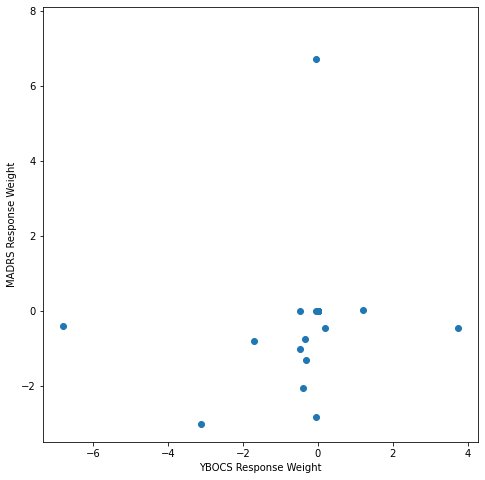

In [50]:
fig,ax=plt.subplots(1,1,figsize=(8,8))

plt.scatter(ybocs_coef_agg.mean(),madrs_coef_agg.mean())
plt.axis('square')
plt.gca().set_aspect('equal',adjustable='box')
ax.set_xlabel('YBOCS Response Weight')
ax.set_ylabel('MADRS Response Weight')

The only thing that's reliable, as just noted, is that VLPFC is particularly bad. This plot might look different if we correlated rank-order in the list, closest to a Q-Q plot. THere is one outlier point at MADRS=7 that's the ACC-PAC, and it only looks weaker on the YBOCS axis because those coefficients in general were smaller.

We look again at the boxplot:

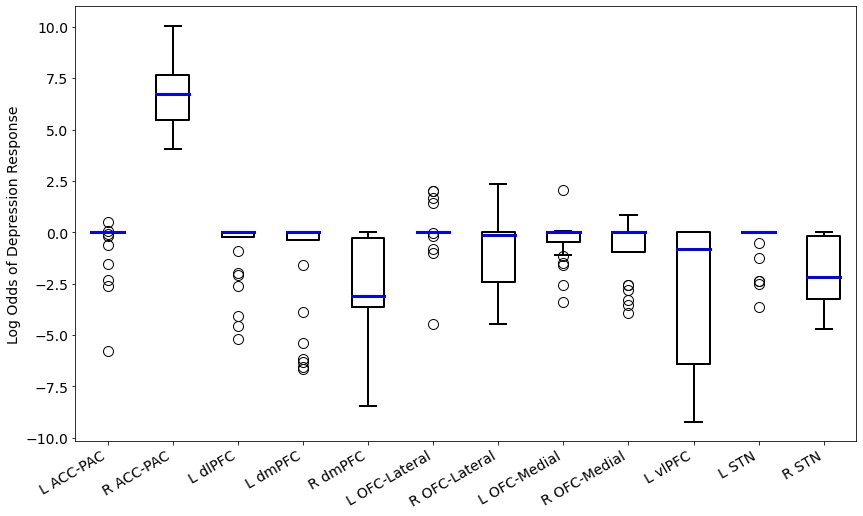

In [51]:
# Pretty ploting of coefficients.
# https://matplotlib.org/examples/pylab_examples/boxplot_demo2.html

# Condense to nonzero coefficients
pretty_plot = madrs_coef_agg.loc[madrs_coef_agg.sum(axis=1)!=0,
                                 (madrs_coef_agg.mean() != 0) & (~madrs_coef_agg.columns.str.contains('Pct'))]

# Replace names
d={'Pct_':'' ,'_T_':' ', '_':' ', 'T ':''}
for k,v in d.items():
    pretty_plot.columns = pretty_plot.columns.str.replace(k,v)

# Styling. This applies to everything we don't overwrite in the "boxplot" call.
boxstyle = dict(linewidth=2,color='black')
medstyle = dict(linewidth=3,color='blue')

f1,a1 = plt.subplots(figsize=(14,8))
p1 = a1.boxplot(pretty_plot,\
                   boxprops=boxstyle,whiskerprops=boxstyle,capprops=boxstyle,\
                   medianprops=medstyle,\
               flierprops=dict(markersize=10))

# I do not know why this needs to be done as this nested call
trash=plt.setp(plt.setp(a1,xticklabels=np.array(pretty_plot.columns)),\
               rotation=30,\
              fontsize=14, \
              ha='right')
trash=plt.setp(a1.get_yticklabels(),\
               fontsize=14)
trash=plt.ylabel("Log Odds of Depression Response",fontsize=14)

plt.savefig("MADRS_Response_Boxplot.png",dpi=300)

COnsistent with what we said above: there is evidence for right ACC as being helpful and left VLPFC as being harmful.

Random forest stuff:

In [52]:
# Aggregator frame for results.
madrs_perm_importance_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)

# Number of permutation runs on each model (doesn't need to be many bc we fit so many models)
# 5 is the default setting for sklearn
nperms = 5

for i in madrs_response_results.loc[madrs_response_results['ModelType'].str.contains('Forest_Pct')].index :
    imp = sklearn.inspection.permutation_importance(madrs_response_results.loc[i,'Model'][0] ,
                                                    response_X.iloc[madrs_response_results.loc[i,'TestIdx'][0],Pct_idx],
                                                    response_Y.iloc[madrs_response_results.loc[i,'TestIdx'][0]],
                                                    n_repeats=nperms)
    madrs_perm_importance_agg.loc[i,response_X.loc[:,Pct_idx].columns] = imp['importances_mean']
    
for i in madrs_response_results.loc[madrs_response_results['ModelType'].str.contains('Forest_T')].index :
    imp = sklearn.inspection.permutation_importance(madrs_response_results.loc[i,'Model'][0] ,
                                                    response_X.iloc[madrs_response_results.loc[i,'TestIdx'][0],T_idx],
                                                    response_Y.iloc[madrs_response_results.loc[i,'TestIdx'][0]],
                                                    n_repeats=nperms)
    madrs_perm_importance_agg.loc[i,response_X.loc[:,T_idx].columns] = imp['importances_mean']

pd.DataFrame(madrs_perm_importance_agg.mean(),columns=['MeanImportance']).sort_values('MeanImportance')

,MeanImportance
L_T_dlPFC,-0.015635
L_Pct_T_dmPFC,-0.011330
L_Pct_T_dlPFC,-0.010367
R_Pct_T_OFC-Medial,-0.008046
L_T_dmPFC,-0.007798
R_T_ACC-PAC,-0.005931
T_All_Regions,-0.005895
R_Pct_T_STN,-0.005400
R_T_STN,-0.004759
R_Pct_T_vlPFC,-0.004626


<AxesSubplot:>

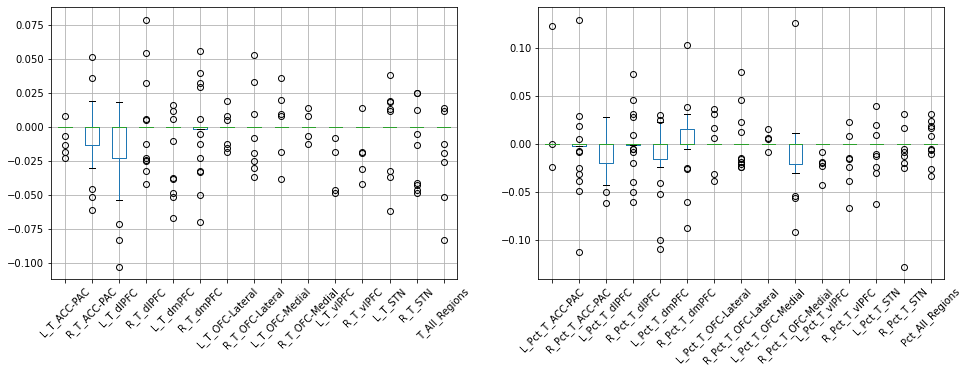

In [53]:
# Boxplot of importance scoring
fig,ax = plt.subplots(1,2,figsize=(16,5))
madrs_perm_importance_agg.loc[:,(madrs_perm_importance_agg.mean() != 0) & (~madrs_perm_importance_agg.columns.str.contains('Pct'))].boxplot(ax=ax[0],rot=45)
madrs_perm_importance_agg.loc[:,(madrs_perm_importance_agg.mean() != 0) & (madrs_perm_importance_agg.columns.str.contains('Pct'))].boxplot(ax=ax[1],rot=45)
#coef_agg.loc[:,(coef_agg.mean() != 0) & (coef_agg.columns.str.contains('Pct'))].boxplot(ax=ax[1],rot=45)

Consistent with the fact that random forest models didn't do very well, all of these CIs cover 0 importance.

# Andreas Horn Style Correlations
Attempting to see whether the diff between us and the LEAD-DBS paper is related to the analytic technique. The Horn approach is to correlate each tract individually with clinical improvement, then report them in order of improvement. Here, we do the correlation AND report the regression performance on a held-out set.

Re-seed the generator again.

In [54]:
num_seeds = ybocs_seeds
random_seed = 55455
gen = np.random.default_rng(random_seed)
model_seeds = gen.integers(1,1e6,size=(1,num_seeds))

In [55]:
# The data are regress_X and regress_Y, which have the NaNs removed and are generally clean.
# They are already scaled.
# regress_groups groups them by subject.

# Usual results dataframe.
horn_corr_results = pd.DataFrame(columns=['SplitIdx','Tract','Train_R','Test_R2','Model','TrainIdx','TestIdx'],
                                 dtype='object')

# We are splitting the dataset in a leave-2-out. I did not split it resp/non-resp as 
# most patients had resp at some point.
split_idx = sklearn.model_selection.LeavePGroupsOut(n_groups=2)

# Iterate through the splits.
split_num=1
for train_idx,test_idx in split_idx.split(regress_X,regress_Y,regress_groups):

    # Split the data according to this training/testing.
    clean_train_X = regress_X.iloc[train_idx]
    clean_train_Y = regress_Y.iloc[train_idx]
    
    clean_test_X = regress_X.iloc[test_idx]
    clean_test_Y = regress_Y.iloc[test_idx]

    # Fit a normalizer to the training set -- then scale both training AND test the same.
    # (It was already normalized, so this is a small shift, but it will ensure no variance leakage.)
    normalizer.fit(clean_train_X.loc[:,T_idx])
    clean_train_X.loc[:,T_idx] = normalizer.transform(clean_train_X.loc[:,T_idx])
    clean_test_X.loc[:,T_idx] = normalizer.transform(clean_test_X.loc[:,T_idx])

    
    # Iterate through the individual tracts to calculate their leverage.
    for col in clean_train_X.columns:
    
        # Aggregate the results, store housekeeping variables
        append_frame = pd.DataFrame(index=[0])
        append_frame['SplitIdx'] = split_num
        append_frame['Tract'] = col
        append_frame['TrainIdx'] = [train_idx]
        append_frame['TestIdx'] = [test_idx]
        
        # Correlation between this tract and YBOCS in the training set
        append_frame['Train_R'] = clean_train_X.loc[:,col].corr(clean_train_Y)
        
        # Predictive performance of that on the test set, straight linear regression.
        mod = sklearn.linear_model.LinearRegression().fit(clean_train_X.loc[:,col].values.reshape(-1,1),
                                                          clean_train_Y)
        append_frame['Test_R2'] = sklearn.metrics.r2_score(clean_test_Y,
                                                           mod.predict(clean_test_X.loc[:,col].values.reshape(-1,1)))
        append_frame['Model'] = [[mod]]
        
        # Add this on to the end of the aggregator.
        horn_corr_results = horn_corr_results.append(append_frame,ignore_index=True,sort=False)
        
        
    # All tracts processed, next split
    split_num = split_num+1
    
# Uncomment for results
#horn_corr_results

Having fit as many single-tract models as we can, we now summarize the results across splits. R is an actual correlation, R2 is the R2-score.

In [56]:
print("Total of ",max(ybocs_results['SplitIdx'])," splits in exhaustive leave-two-out")
model_grouped=horn_corr_results.groupby('Tract')
model_summ = model_grouped.agg([np.median, 
                               lambda x: x.median() - (2*x.std()) ,
                               lambda x: x.median() + (2*x.std())]).rename(columns={'median':'median', '<lambda_0>' : 'CI_lower' , '<lambda_1>' : 'CI_upper'})

Total of  28  splits in exhaustive leave-two-out


In [57]:
# This cell is just pretty-printing code for the result above.
pretty_t = model_summ.\
rename(columns={'median':'Median', 'CI_lower' : 'CI Lower Bound' , 'CI_upper' : 'CI Upper Bound',\
                'Train_R':'Training Set R','Test_R2':'Test Set $R^2$'}).\
reindex(model_summ.loc[:,[('Train_R','median')]].abs().sort_values(ascending=False,by=('Train_R','median')).index)

# For separating results by modeling type
Pct_plot_idx = (pretty_t.index.str.contains('Pct'))
T_plot_idx = (~pretty_t.index.str.contains('Pct'))

# This makes the index labels look nice
d={'Pct_':'' ,'_T_':' ', '_':' ', 'T ':''}
for k,v in d.items():
    pretty_t.index = pretty_t.index.str.replace(k,v)


# # This is the code for pretty-printing that same dataframe
# # Stylers are how you format columns: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# #  look at the "slicing" piece of it, and the "Display Values" piece..
# # We may also want to use option_context, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.option_context.html#pandas.option_context

# Formatter for making bolding. Treats the sets of columns separately.
def bold_signif(s):
    # For the training R: does the CI exclude zero?
    if ( (np.sign(s[1]) == np.sign(s[2])) & \
        (np.abs(s[0]) > 1e-3) ):
        output = pd.Series(['font-weight: bold','',''])
    else:
        output = pd.Series(['','',''])
    
    if ((s[3] > 0) & \
       (s[4]>0)):
        output = output.append(pd.Series(['font-weight: bold','','']))
    else:
        output = output.append(pd.Series(['','','']))

    return output

# Print with the formatters applied.
display(pretty_t.loc[T_plot_idx,:].\
        style.set_caption("Total Fibers").\
        format("{:.3f}").\
        apply(bold_signif,axis=1))

display(pretty_t.loc[Pct_plot_idx,:].\
        style.set_caption("Percentage Fibers").\
        format("{:.3f}").\
        apply(bold_signif,axis=1))

t=pretty_t

In the training set, only one thing, the ACC, has a CI excluding zero to predict response. All others have negative correlation with response if they're significant at all. Note again that in this dataset, STN fiber capture predicts worseing.

None show a positive R2 on the test set, i.e. none of these generalize outside their training data.

We also make one version of this that prints only training-set-significant items, in one table.

In [58]:
pretty_t=t

# This helps us segregate which vsriable is which type.
i = pd.Series(pretty_t.index)  # you can't change indexes directly
i[Pct_plot_idx] = i[Pct_plot_idx].astype(str) + ' (Percentage)'
i[T_plot_idx] = i[T_plot_idx].astype(str) + ' (Total Fibers)'
pretty_t.index = i

# This identifies the signifcant training set
train_sig_idx = np.sign(pretty_t.loc[:,('Training Set R','CI Lower Bound')]) ==\
 np.sign(pretty_t.loc[:,('Training Set R','CI Upper Bound')])
pretty_t.loc[train_sig_idx,].\
sort_values(by=('Training Set R','Median')).\
style.format("{:.3f}")

Report how much STN fiber capture we actually had. It is some. Hence why we have negative coefficients.

In [59]:
dat.loc[:,['Subject','L_T_STN','R_T_STN']].agg([np.mean,np.median,np.std])


,L_T_STN,R_T_STN
mean,17.533333,8.406061
median,3.000000,2.000000
std,38.509348,13.910821


# Tract Integrity and Response
Test the possibility that response depends not on what was in VTA, but overall integrity of tracts.

First, load the data. These are standardized by divdiding by the intracranial volume (ICV) of each subject, so that more fibers is not affected by bigger head.

In [60]:
# Get fiber tract integrity (total streamline count) data.
integrity_dat = pd.read_excel('/Users/alik/Documents/Research/Project Performance/StimVision OCD/2021 YBOCS Modeling Paper/DBS OCD Fiber Analysis August 2021 Cleaned For Distribution.xlsx',
                             sheet_name='Total Fiber Count')

# Get intracranial volume per subject
icv_dat = pd.read_excel('/Users/alik/Documents/Research/Project Performance/StimVision OCD/2021 YBOCS Modeling Paper/DBS OCD Fiber Analysis August 2021 Cleaned For Distribution.xlsx',
                             sheet_name='ICV')

# Normalize the numeric columns
number_cols = list(set(integrity_dat.columns) - set(['Subject','YBOCS_Resp','MADRS_Resp']))
                                                     
for c in number_cols:
    integrity_dat[c] = integrity_dat[c] / icv_dat['ICV_cc']
                              

# Add a mean integrity column.
integrity_dat.loc[:,"Mean_Integrity"] = integrity_dat.loc[:,integrity_dat.columns.str.contains('_T_')].mean(axis=1)

# Pull in whether the subject ever responded.

for s in integrity_dat['Subject']:
# Do they spend most of time in response, after
#. at least 3 months have elapased?
    s_idx = (dat.Subject == s)
    mo3_idx = (dat.loc[s_idx,'Treatment_Weeks']  >=  12)
    
    integrity_dat.loc[integrity_dat.Subject == s,'YBOCS_Resp'] = \
        (np.sum(dat.loc[s_idx,'YBOCS_Response'][mo3_idx].dropna())/np.sum(mo3_idx)) >= 0.4
    integrity_dat.loc[integrity_dat.Subject == s,'MADRS_Resp'] = \
        (np.sum(dat.loc[s_idx,'MADRS_Response'][mo3_idx].dropna())/np.sum(mo3_idx)) >= 0.4

# Send a copy to R.
integrity_dat.to_csv(r'/Users/alik/Documents/Research/Project Performance/StimVision OCD/2021 YBOCS Modeling Paper/DBS OCD Fiber Analysis Integrity Summary.csv',index=False)

# Sanity check/viewing.
integrity_dat



,Subject,L_T_ACC_PAC,L_T_dlPFC,L_T_dmPFC,L_T_OFC-Lateral,L_T_OFC-Medial,L_T_vlPFC,L_T_STN,R_T_ACC_PAC,R_T_dlPFC,R_T_dmPFC,R_T_OFC-Lateral,R_T_OFC-Medial,R_T_vlPFC,R_STN,Mean_Integrity,YBOCS_Resp,MADRS_Resp
0,A,0.064315,0.280183,0.305655,0.016556,0.029292,0.413907,0.219689,0.155374,0.331126,1.083164,0.015920,0.009552,0.690907,0.115257,0.278126,False,False
1,B,0.186758,0.506038,1.076034,0.012280,0.055260,0.278858,0.025072,0.160151,0.318768,1.717663,0.012792,0.032747,0.712751,0.024560,0.391936,True,False
2,C,0.003280,0.062971,0.116760,0.000000,0.001968,0.074779,0.004592,0.001968,0.166612,0.238767,0.000000,0.000000,0.041325,0.005248,0.054848,False,False
3,D,0.279734,0.364400,0.668518,0.080601,0.079924,0.472772,0.092793,0.209970,0.342048,0.587917,0.056895,0.023029,0.169331,0.102276,0.263687,True,False
4,E,0.147757,0.470317,0.833773,0.042876,0.089050,0.057388,0.104881,0.295515,1.079156,0.992744,0.007916,0.011214,0.417546,0.104222,0.350010,False,False
5,F,0.194219,0.397614,0.871183,0.038232,0.091757,0.225825,0.054035,0.263037,0.301779,1.205587,0.051486,0.126421,0.688179,0.074425,0.346873,False,False
6,G,0.311417,0.654983,1.326987,0.017651,0.041606,0.144991,0.567358,0.156339,0.412911,0.588792,0.016390,0.056105,0.148774,0.165795,0.341870,True,False
7,H,0.098247,0.309406,0.805775,0.099714,0.307940,0.083584,0.102647,0.127575,0.257349,1.283082,0.043258,0.115844,0.197961,0.175965,0.294799,False,False


Then, as in our prior response predictions, fit a large number of regularized predictors and report what survives.

In [61]:
num_seeds = ybocs_seeds
random_seed = 55455
gen = np.random.default_rng(random_seed)
model_seeds = gen.integers(1,1e6,size=(1,num_seeds))

In [62]:
# Setup regression inputs.
# We consider the fiber data as already normalized.
integrity_X = integrity_dat.drop(columns=['Subject','YBOCS_Resp','MADRS_Resp'])
integrity_Y = integrity_dat['YBOCS_Resp']
integrity_groups = integrity_dat.loc[integrity_X.index,'Subject']


# Perform model fitting.
# Aggregator dataframe for results
integrity_results = pd.DataFrame(columns=['SplitIdx','ModelType','Accuracy','BalancedAccuracy','Recall','Model','TrainIdx','TestIdx'],
                                          dtype='object')

# Helper function to extract core variables from a model and package things like the training/test sets for 
# future re-use.
def summarize_class_scores(model,test_X,test_Y,ModelType,SplitIdx):
    ret_frame = pd.DataFrame(index=[0])
    ret_frame['ModelType'] = ModelType
    ret_frame['SplitIdx'] = SplitIdx
    ret_frame['Accuracy'] = model.score(test_X,test_Y)
    ret_frame['BalancedAccuracy'] = sklearn.metrics.balanced_accuracy_score(test_Y,model.predict(test_X))
    ret_frame['Recall'] = sklearn.metrics.recall_score(test_Y,model.predict(test_X))

    # All of these are wrappers around things we'd need to re-run/re-calculate scores.
    ret_frame['Model'] = [[model]]   # This is buried in a list so we can use models of different types

    return ret_frame

# We do not SMOTE bc dataset is too small.

# Leave-two-out splitter.
split_idx=sklearn.model_selection.LeavePGroupsOut(n_groups=2)

# Iterate through the splits.
split_num=1

for train_idx,test_idx in split_idx.split(integrity_X,integrity_Y,integrity_groups):

    # Split the data according to this training/testing.
    clean_train_X = integrity_X.iloc[train_idx]
    clean_train_Y = integrity_Y.iloc[train_idx]
    
    clean_test_X = integrity_X.iloc[test_idx]
    clean_test_Y = integrity_Y.iloc[test_idx]

    #This is where we would normalize but are not normalizing for this dataset

    # No resampling here. 
    resamp_X =clean_train_X
    resamp_Y = clean_train_Y
    
#     # Every so often, we get a test fold that doesn't have any TRUE or FALSE responses. Randomly flip one.
# (This was removed b/c it is only needed for AUC calculation.)
#     if sum(clean_test_Y) == 0:
#         clean_test_Y.iloc[np.random.randint(1,len(clean_test_Y))]=True
#     if sum(clean_test_Y) == len(clean_test_Y):
#         clean_test_Y.iloc[np.random.randint(1,len(clean_test_Y))]=False
        
        
    
    # Fit L1 Penalized Logistic Regression - trying to shrink coefficients.
    mod_l1logit_integ = sklearn.linear_model.LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',max_iter=1000).fit(resamp_X,resamp_Y.astype('bool'))
    integrity_results = integrity_results.append( \
        summarize_class_scores(mod_l1logit_integ,clean_test_X,clean_test_Y.astype('bool'),'L1Logistic_Integ',split_num),ignore_index=True,sort=False)

    # Store the train/test indexes. The call to tail() gets the rows we just filled. We need to pull their actual numeric index
    # in order to feed it to loc[] so we can then index the specific column.
    # And we wrap the relevant lists inside another list so that it all fits in one dataframe cell.
    # This is probably an abuse of dataframes.
    for j in integrity_results.tail(1).index:
        integrity_results.at[j,'TrainIdx'] = [train_idx]
        integrity_results.at[j,'TestIdx'] = [test_idx]

    # Move forward the CV iterator
    split_num = split_num+1

    
# Uncomment to see the output
#integrity_results

In [63]:
print("Total of ",max(integrity_results['SplitIdx'])," splits in exhaustive leave-two-out")
model_grouped = integrity_results.groupby('ModelType')
model_grouped.agg([np.median, 
                   lambda x: x.median() - (2*x.std()) ,
                   lambda x: x.median() + (2*x.std())]).rename(columns={'median':'median', '<lambda_0>' : 'CI_lower' , '<lambda_1>' : 'CI_upper'})

Total of  28  splits in exhaustive leave-two-out


Accuracy                     BalancedAccuracy            \
                   median  CI_lower  CI_upper           median  CI_lower   
ModelType                                                                  
L1Logistic_Integ      0.5 -0.066947  1.066947              0.5 -0.066947   

                           Recall                      
                  CI_upper median  CI_lower  CI_upper  
ModelType                                              
L1Logistic_Integ  1.066947    0.0 -0.780042  0.780042

In [64]:
# This is the code for pretty-printing that same dataframe
# Stylers are how you format columns: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
#  look at the "slicing" piece of it, and the "Display Values" piece..
# We may also want to use option_context, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.option_context.html#pandas.option_context

model_grouped = integrity_results.groupby('ModelType')
print_model_grouped = model_grouped.agg([np.median, 
                   lambda x: x.median() - (2*x.std()) ,
                   lambda x: x.median() + (2*x.std())]).rename(columns={'median':'Median', '<lambda_0>' : 'CI Lower Bound' , '<lambda_1>' : 'CI Upper Bound'})
print_model_grouped.columns.set_levels(['Accuracy','Balanced Accuracy','Recall'],level=0,inplace=True)
print_model_grouped = print_model_grouped.drop(columns=['Accuracy','Recall'])
print_model_grouped[np.abs(print_model_grouped) < 1e-8] = 0
print_model_grouped.index.names = ['Model Type']
print_model_grouped.index = pd.Index(['L1 Logistic (Fiber Integrity)'])

display(print_model_grouped.style.format("{:.3f}"))

In other words, the aggregate model still feels that calling the majority class is the right thing to do, and cannot reliably gain information above that.

Coefficient scoring:

In [65]:
# Obtain the mean coefficient values for each type of model.
integrity_coef_agg = pd.DataFrame(columns=clean_test_X.columns,dtype=float)
for i in integrity_results.loc[integrity_results['ModelType'].str.contains('Logistic')].index :
    integrity_coef_agg.loc[i,clean_test_X.columns] = integrity_results.loc[i,'Model'][0].coef_[0]

t = pd.concat([integrity_coef_agg.mean(),integrity_coef_agg.std()],axis=1)
t.columns = ['CoeffMean','CoeffStd']
t.sort_values('CoeffMean')

,CoeffMean,CoeffStd
L_T_ACC_PAC,0.000000,0.000000
L_T_dlPFC,0.000000,0.000000
L_T_OFC-Lateral,0.000000,0.000000
L_T_OFC-Medial,0.000000,0.000000
L_T_vlPFC,0.000000,0.000000
L_T_STN,0.000000,0.000000
R_T_ACC_PAC,0.000000,0.000000
R_T_dlPFC,0.000000,0.000000
R_T_OFC-Lateral,0.000000,0.000000
R_T_OFC-Medial,0.000000,0.000000


In [66]:
# Pretty-print coefficients table.
pretty_t = t.sort_values('CoeffMean')
pretty_t.columns = pd.Index(['Mean Coefficient','SD'])
#pretty_t.index.rename((pd.Series(pretty_t.index.array).replace(regex={r'Pct_':'' ,'_T_':' ', '_':' '})))
d={'Pct_':'' ,'_T_':' ', '_':' '}
for k,v in d.items():
    pretty_t.index = pretty_t.index.str.replace(k,v)

def bold_signif(s):
    if (np.abs(s[0]) >= (2*s[1])) & (np.abs(s[0] != 0)):
        return pd.Series(['font-weight: bold',''])
    else:
        return pd.Series(['',''])
    
display(pretty_t.style.\
        format("{:.3f}").\
        apply(bold_signif,axis=1))


,Mean Coefficient,SD
L ACC PAC,0.000,0.000
L dlPFC,0.000,0.000
L OFC-Lateral,0.000,0.000
L OFC-Medial,0.000,0.000
L vlPFC,0.000,0.000
L STN,0.000,0.000
R ACC PAC,0.000,0.000
R dlPFC,0.000,0.000
R OFC-Lateral,0.000,0.000
R OFC-Medial,0.000,0.000


That does not look very useful. What about a mass-univariate approach?

This next table is the result of fitting many non-penalized logistic regressions, tract by tract, on the integrity data.

In [67]:
# We are using the same data as above, and they are already grouped.

# Usual results dataframe.
horn_integrity_results = pd.DataFrame(columns=['SplitIdx','Tract','Train_BalAcc','Test_BalAcc','Model','TrainIdx','TestIdx'],
                                 dtype='object')

# We are splitting the dataset in a leave-2-out. I did not split it resp/non-resp as 
# most patients had resp at some point.
split_idx = sklearn.model_selection.LeavePGroupsOut(n_groups=2)

# Iterate through the splits.
split_num=1
for train_idx,test_idx in split_idx.split(integrity_X,integrity_Y,integrity_groups):

    # Split the data according to this training/testing.
    clean_train_X = integrity_X.iloc[train_idx]
    clean_train_Y = integrity_Y.iloc[train_idx].astype('bool')
    
    clean_test_X = integrity_X.iloc[test_idx]
    clean_test_Y = integrity_Y.iloc[test_idx].astype('bool')


    # No normalizer here.
    
    # Iterate through the individual tracts to calculate their leverage.
    for col in clean_train_X.columns:
    
        # Aggregate the results, store housekeeping variables
        append_frame = pd.DataFrame(index=[0])
        append_frame['SplitIdx'] = split_num
        append_frame['Tract'] = col
        append_frame['TrainIdx'] = [train_idx]
        append_frame['TestIdx'] = [test_idx]
        
        # Fit a simple logistic regression
        mod = sklearn.linear_model.LogisticRegression().fit(clean_train_X.loc[:,col].values.reshape(-1,1),
                                                          clean_train_Y)

        # Performance in the training set
        append_frame['Train_BalAcc'] = sklearn.metrics.balanced_accuracy_score(clean_train_Y,
                                                           mod.predict(clean_train_X.loc[:,col].values.reshape(-1,1)))        
        
        # Predictive performance of that on the test set, straight linear regression.
        append_frame['Test_BalAcc'] = sklearn.metrics.balanced_accuracy_score(clean_test_Y,
                                                           mod.predict(clean_test_X.loc[:,col].values.reshape(-1,1)))
        append_frame['Model'] = [[mod]]
        
        # Add this on to the end of the aggregator.
        horn_integrity_results = horn_integrity_results.append(append_frame,ignore_index=True,sort=False)
        
        
    # All tracts processed, next split
    split_num = split_num+1
    
# Uncomment for results
#horn_integrity_results

In [68]:
print("Total of ",max(horn_integrity_results['SplitIdx'])," splits in exhaustive leave-two-out")
model_grouped=horn_integrity_results.groupby('Tract')
model_summ = model_grouped.agg([np.median, 
                               lambda x: x.median() - (2*x.std()) ,
                               lambda x: x.median() + (2*x.std())]).rename(columns={'median':'median', '<lambda_0>' : 'CI_lower' , '<lambda_1>' : 'CI_upper'})

# This cell is just pretty-printing code for the result above.
pretty_t = model_summ.\
rename(columns={'median':'Median', 'CI_lower' : 'CI Lower Bound' , 'CI_upper' : 'CI Upper Bound',\
                'Train_BalAcc':'Training Set Balanced Accuracy','Test_BalAcc':'Test Set Balanced Accuracy'}).\
reindex(model_summ.loc[:,[('Train_BalAcc','median')]].abs().sort_values(ascending=False,by=('Train_BalAcc','median')).index)

# This makes the index labels look nice
d={'Pct_':'' ,'_T_':' ', '_':' ', 'T ':''}
for k,v in d.items():
    pretty_t.index = pretty_t.index.str.replace(k,v)


# # This is the code for pretty-printing that same dataframe
# # Stylers are how you format columns: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# #  look at the "slicing" piece of it, and the "Display Values" piece..
# # We may also want to use option_context, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.option_context.html#pandas.option_context

# Formatter for making bolding. Treats the sets of columns separately.
def bold_signif(s):
    # For the training R: does the CI exclude zero?
    if ( (s[0] > 0.5) & (s[1] > 0.5) ):
        output = pd.Series(['font-weight: bold','',''])
    else:
        output = pd.Series(['','',''])
    
    if ((s[3] > 0.5) & (s[4] > 0.5)):
        output = output.append(pd.Series(['font-weight: bold','','']))
    else:
        output = output.append(pd.Series(['','','']))

    return output

# Print with the formatters applied.
display(pretty_t.sort_values(('Training Set Balanced Accuracy','CI Lower Bound')).\
        style.format("{:.3f}").\
        apply(bold_signif,axis=1))

t=pretty_t

Total of  28  splits in exhaustive leave-two-out


That is, nothing has an accuracy above chance on the test set.

# Fibers and Charge Density

This responds to a reviewer question about whether we proved that we had greater fiber engagement with increasing charge delivery.

In [69]:
density_dat = regress_X.loc[:,['T_All_Regions']].join(dat.loc[:,['L_Charge','R_Charge']])
density_dat['T_All_Left'] = (regress_X.loc[:,regress_X.columns.str.contains('L_T_')].sum(axis=1))
density_dat['T_All_Right'] = (regress_X.loc[:,regress_X.columns.str.contains('R_T_')].sum(axis=1))
density_dat['Total_Charge'] = density_dat['L_Charge'] + density_dat['R_Charge']
density_dat.dropna(axis='index',inplace=True)
density_dat

,T_All_Regions,L_Charge,R_Charge,T_All_Left,T_All_Right,Total_Charge
0,0.641368,0.630,0.225564,2.810807,2.992270,0.855564
1,0.641368,0.480,0.225564,2.810807,2.992270,0.705564
2,0.877703,0.480,0.453782,3.342737,3.619112,0.933782
3,1.000000,0.990,0.451436,3.504769,4.337120,1.441436
4,0.406213,1.080,0.000000,3.840322,0.000000,1.080000
...,...,...,...,...,...,...
160,0.325993,0.375,0.545822,2.339064,1.163096,0.920822
161,0.325993,0.375,0.534301,2.339064,1.163096,0.909301
162,0.325993,0.375,0.530105,2.339064,1.163096,0.905105
163,0.325993,0.375,0.525974,2.339064,1.163096,0.900974


In [70]:
scipy.stats.pearsonr(density_dat['Total_Charge'],density_dat['T_All_Regions'])

(0.26114526767378643, 0.002396506827596222)

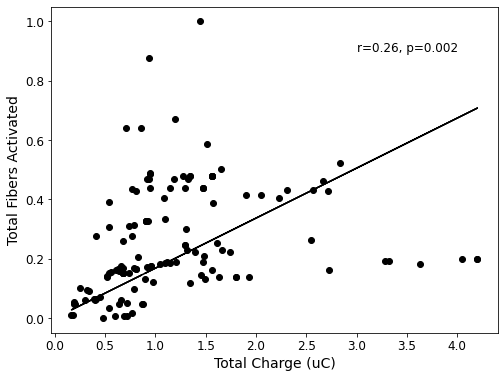

In [71]:
f1,a1 = plt.subplots(figsize=(8,6))

# Scatterplot
a1.plot(density_dat['Total_Charge'],density_dat['T_All_Regions'],'ok')

# Regression line (need to update with a robust regressor)
# m,b = np.polyfit(density_dat['Total_Charge'],density_dat['T_All_Regions'],1)
# a1.plot(density_dat['Total_Charge'], m*density_dat['Total_Charge'] + b,'-k')
line_mod = sklearn.linear_model.RANSACRegressor(random_state=55455)
line_mod.fit(density_dat['Total_Charge'].to_numpy().reshape(-1,1),density_dat['T_All_Regions'])
a1.plot(density_dat['Total_Charge'],line_mod.predict(density_dat['Total_Charge'].to_numpy().reshape(-1,1)),'-k')

# Label
a1.text(3.0,0.9,
        "r=%.2f, p=%.3f" % \
        (scipy.stats.pearsonr(density_dat['Total_Charge'],density_dat['T_All_Regions'])),
       fontsize=12)

# Formatting
#trash = plt.xticks(np.arange(0.1,1.0,0.2))
trash = plt.setp(a1.get_xticklabels(),fontsize=12)
trash = plt.setp(a1.get_yticklabels(),fontsize=12)
trash = plt.xlabel('Total Charge (uC)',fontsize=14)
trash = plt.ylabel('Total Fibers Activated',fontsize=14)

plt.savefig("Fiber_Activation_vs_Charge",dpi=300)

In other words, yes, we do.